## Load data

In [8]:
import numpy as np
import _pickle as pkl
import torch
import torch.nn as nn
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray, load_vh_models, frame_stack
set_seed_torch(3)
from train import encode
from argparse import Namespace
import json
import gzip

In [12]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({
 'res': 64,
#  'dataset_path': ['/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
#                    .format("vha1_2D_len16_oscxy_withGT_0B7AB071F98942578ABDA66879290F2F.pkl"),
#                   '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
#                    .format("vha2_2D_len16_oscxy_withGT_3502DE81F7C343FB8B57FA92FDECF4DA.pkl"),
#                   '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
#                    .format("vha3_2D_len16_oscxy_withGT_5DB32B21A6AA4E5892D2F6B8F40EF9E6.pkl")
#                  ],
#  'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
#                    .format("ablation"),
#  'n_pred': 13,
 'dataset_path': ['/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/mit_push/{}'
                   .format("min-tr2.5_min-rot0.5_len48.pkl")
                 ],
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("mit"),
 'n_pred': 45,
 'device': 'cuda:1',
 'n_examples': 32,
 'n_initial': 2
})

def load_models_dir(models_dir):
    """Load hyperparameters from trained model."""
    dict_of_models = {}
    for filedir in os.listdir(models_dir):
        fullpath = os.path.join(models_dir, filedir)
        if os.path.isdir(fullpath):
            with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
                dict_of_models[fullpath] = Namespace(**json.load(fp))
    return dict_of_models

def is_gz_file(filepath):
    with open(filepath, 'rb') as test_f:
        return test_f.read(2) == b'\x1f\x8b'
    
data = {
#     'img_rgb': [],
    'img_gray': [],
    'haptic': [],
    'arm': [],
    'actions': []
}

for dataset_path in args.dataset_path:
    if is_gz_file(dataset_path):
        with gzip.open(dataset_path, 'rb') as f:
            raw_data = pkl.load(f)
    else:
        with open(dataset_path, 'rb') as f:
            raw_data = pkl.load(f)

#     data['img_rgb'].append(torch.from_numpy(raw_data["img"].transpose(0, 1, 4, 2, 3)).int().to(device=args.device))
    data['img_gray'].append(torch.from_numpy(rgb2gray(raw_data["img"]).transpose(0, 1, 4, 2, 3)).float().to(device=args.device))
    data['haptic'].append(torch.from_numpy(raw_data['ft']).float().to(device=args.device))
    data['arm'].append(torch.from_numpy(raw_data['arm']).float().to(device=args.device))
    data['actions'].append(torch.from_numpy(raw_data["action"]).to(device=args.device).float())

data = {k:torch.cat(v, dim=0) for k,v in data.items()}

## Visualize

In [13]:
dict_of_models = load_models_dir(args.models_dir)
val_idx = None
analysis_data = {}

with torch.no_grad():
    for path, model_args in dict_of_models.items():
        nets = load_vh_models(path=path, args=model_args, mode='eval', device=args.device)
        analysis_data[path] = {}

#         if model_args.dim_x[0] == 1:
#             img_key = 'img_gray'
#         elif model_args.dim_x[0] == 3:
#             img_key = 'img_rgb'
        img_key = 'img_gray'
        
        # XXX: Assume same validation indices for all models, then we can compare on the same examples
        if val_idx is None:
            # Use validation indices only
            with open(os.path.join(path, "val_idx.pkl"), 'rb') as f:
                val_idx = pkl.load(f)
            data_val = {k:v[val_idx] for k,v in data.items()}

            # Use a random batch to test
            ii = np.random.randint(data_val[img_key].shape[0] // args.n_examples)
            batch_range = range(args.n_examples*ii, args.n_examples*(ii+1))
            test_batch = {k:v[batch_range] for k,v in data_val.items()}

        T = model_args.frame_stacks
        
        assert args.n_initial + args.n_pred <= data_val[img_key].shape[1]
        assert args.n_initial > T
        
        # Set up data for batch
        x_img = test_batch[img_key][:, :(args.n_initial + args.n_pred)]
        x_ft = test_batch['haptic'][:, :(args.n_initial + args.n_pred)]
        x_arm = test_batch['arm'][:, :(args.n_initial + args.n_pred)]
        u = test_batch['actions']
        x_i = {}
        
        # Sequence of initial images
        x_img_i = x_img[:, :args.n_initial]
        x_img_i = frame_stack(x_img_i, frames=T)
        n, l = x_img_i.shape[0], x_img_i.shape[1] 
        x_i["img"] = x_img_i
        
        # Sequence of extra modalities
        x_ft_i = x_ft[:, :args.n_initial] / model_args.ft_normalization
        x_arm_i = x_arm[:, :args.n_initial]
        u_i = u[:, T:args.n_initial]

        if model_args.context_modality != "none":
            if model_args.context_modality == "joint":
                x_i["context"] = torch.cat((x_ft_i, x_arm_i), dim=-1)
            elif model_args.context_modality == "ft":
                x_i["context"] = x_ft_i
            elif model_args.context_modality == "arm":
                x_i["context"] = x_arm_i
                
            if model_args.use_context_frame_stack:
                x_i['context'] = frame_stack(x_i['context'], frames=T)
            else:
                x_i["context"] = x_i["context"][:, T:]
            x_i["context"] = x_i["context"].transpose(-1, -2)
            
        x_i = {k:v.reshape(-1, *v.shape[2:]) for k, v in x_i.items()}

        # Encode
        if model_args.use_prior_expert:
            q_z_i, _, _ = encode(nets, model_args, x_i, u_i, device=args.device)
        else:
            q_z_i = encode(nets, model_args, x_i, u_i, device=args.device)

        # Group and prepare for prediction
        q_z_i = {k:v.reshape(n, l, *v.shape[1:]).transpose(1,0) for k, v in q_z_i.items()}
        u = u.transpose(1,0)

        z_hat = torch.zeros(((l + args.n_pred), n, model_args.dim_z)).to(device=args.device)
        z_hat[0:l] = q_z_i["mu"]
        
        # First run
        z_i, mu_z_i, var_z_i = q_z_i["z"], q_z_i["mu"], q_z_i["cov"]
        u_pred = u[(T + 1):(1 + args.n_initial)]
        h_i = None

        # Predict
        for jj in range(0, args.n_pred):
            z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = nets["dyn"](
                z_t=z_i, 
                mu_t=mu_z_i, 
                var_t=var_z_i, 
                u=u_pred, 
                h_0=h_i, 
                single=False
            )
            z_hat[jj + l] = mu_z_ip1[-1]
            z_i, mu_z_i, var_z_i, h_i = z_ip1[-1:], mu_z_ip1[-1:], var_z_ip1[-1:], h_ip1
            u_pred = u[1 + args.n_initial + jj][None]
                        
        # Decode
        z_hat = z_hat.transpose(1, 0)
        x_hat = nets["img_dec"](z_hat.reshape(-1, *z_hat.shape[2:]))
        x_hat = x_hat.reshape(n, (l + args.n_pred), *x_hat.shape[1:])

        # Move to cpu, np
        x_hat = x_hat.cpu().numpy()
        x_img = x_img.cpu().numpy()

        mse = np.sum((x_hat[:, l:, 0].reshape(n, args.n_pred, -1) - 
                      x_img[:, args.n_initial:, 0].reshape(n, args.n_pred, -1))**2, axis=2)
        
        analysis_data[path]["x_img"] = x_img
        analysis_data[path]["x_hat"] = x_hat
        analysis_data[path]["mse"] = mse

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487684_mit_nstep2_1024optbase_noAnnealkl_noWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vha_r1.00_kl1.00_lr3e4
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487679_mit_nstep2_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_v_r1.00_kl1.00_lr3e4
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487685_mit_nstep2_1024optbase_noAnnealkl_noWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vh_r1.00_kl1.00_lr3e4
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487682_mit_nstep2_1024optbase_noAnnealkl_noWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_va_r1.00_kl1.00_lr3e4


/home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487684_mit_nstep2_1024optbase_noAnnealkl_noWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vha_r1.00_kl1.00_lr3e4
MSE of predictions:  [0.20460624 0.16824263 0.477421   0.44349086 0.22300223 0.21288678
 0.33277476 0.3042556  0.408225   0.33125913 0.7140573  0.3763653
 0.40625316 0.45113048 0.53909403 0.5052012  0.5972156  0.6668004
 0.6316763  0.72530174 0.75381017 0.82880414 1.0128429  0.94250035
 1.11454    1.1825442  1.1244962  1.2530999  1.2911092  1.3471484
 1.5440722  1.6535901  1.7130467  1.6485626  1.8615519  1.9409093
 2.189946   2.0646663  2.1628504  2.2493005  2.353023   2.7814806
 2.545929   2.7006075  2.9294455 ]


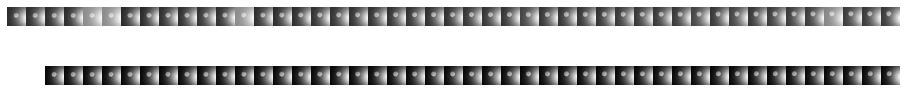

MSE of predictions:  [1.3194212  1.2943224  1.3658986  0.6719549  0.27116123 0.27500105
 0.71558565 0.71492565 0.2566403  0.2590886  0.17152765 0.18003693
 0.5994155  0.2542536  0.2618246  0.26635596 0.18384694 0.18875211
 0.6657976  0.25932267 0.25754887 0.26732907 0.2775139  0.28906238
 0.30585074 0.39570856 0.404785   0.3541438  0.3661693  0.39000076
 0.39213088 0.39443818 0.4023321  0.41279855 0.33577558 0.34386832
 0.4353301  0.45173022 0.46987215 0.36794043 0.3866161  0.38739526
 0.47422242 0.48710832 0.47886997]


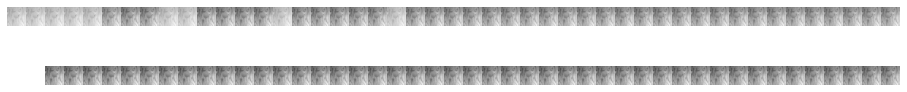

MSE of predictions:  [0.3417358  0.31589058 0.32007602 0.37912536 0.162264   0.16200389
 0.567067   0.24340045 0.39187065 0.25817987 0.2523391  0.2472539
 0.6630165  0.4109903  0.25746328 0.24926975 0.24572082 0.2313981
 0.6877375  0.6772146  0.6672179  0.571155   0.49447358 0.59608
 0.2556392  0.25323793 0.25000528 0.16902274 0.1713992  0.26878324
 0.27090853 0.41411883 0.19455856 0.3027547  0.29667863 0.7340424
 0.28948084 0.31429645 0.3106251  0.30512437 0.31059352 0.91084385
 1.0784719  0.3607705  0.3704828 ]


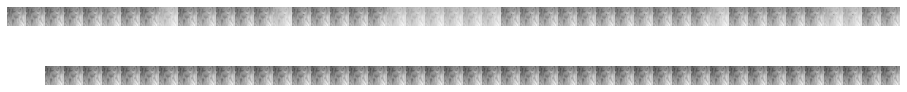

MSE of predictions:  [0.72494435 0.9515032  0.9711876  0.5856944  0.5887668  0.9421152
 0.80363715 0.775161   0.80120474 0.6120596  1.20226    1.0768198
 0.7462858  0.78861976 0.6282563  0.8875956  0.9691139  0.8705957
 1.4354662  0.82093596 0.84703547 0.82165444 1.2751731  0.8278532
 0.7963928  0.80818594 1.0945339  1.0502696  0.9835227  0.9644383
 1.3693607  1.0351498  0.85207325 0.85057974 0.7255443  0.7798492
 0.9474052  0.9673275  1.4650226  1.028038   1.0519351  1.0660402
 1.1182809  1.1035042  1.1500545 ]


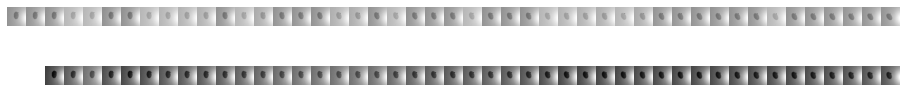

MSE of predictions:  [0.7833614  0.7426246  0.915983   0.7242409  0.81621486 1.241096
 1.4016615  1.3591492  1.5388994  1.3694273  1.4134763  1.4217162
 2.434525   2.0395138  1.3388873  1.4805988  1.5935285  1.9843533
 2.0042815  1.7490224  1.6860492  1.7723446  1.9449373  2.1744323
 1.9089274  2.1842945  1.952719   1.8186116  2.278212   2.2206755
 2.1539466  2.1673815  1.9754641  2.4379697  2.356071   2.3167603
 2.4047375  2.310958   2.530115   3.1923895  2.914439   2.9712071
 3.0310147  3.3623364  3.4776826 ]


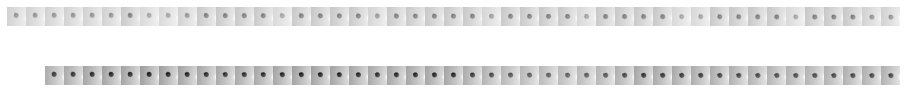

MSE of predictions:  [0.36277315 0.32281253 0.24445198 0.34195682 0.9204493  0.8287145
 0.7945477  0.95597786 0.8511733  1.1274587  1.1393054  1.1805056
 1.15641    1.0064309  1.1384265  1.3001628  1.2886918  1.6549037
 1.7274241  1.6226407  1.6581659  1.6774174  1.7906412  2.4622397
 1.9541383  2.0470672  2.1622596  2.1174226  2.0275779  2.16615
 2.0444975  2.4164293  2.2334328  2.986411   2.57506    2.665175
 2.2919571  2.257224   2.3350272  2.700855   2.8908408  2.9798384
 2.7427197  2.94165    3.1233077 ]


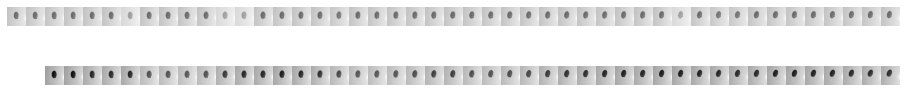

MSE of predictions:  [0.79315954 0.4459405  0.42760974 0.31485772 0.3165957  0.4587098
 0.4775327  0.48502287 0.46808243 0.33216107 0.33081853 0.35488367
 0.49325287 0.52861834 0.45118725 0.7328809  0.44349077 0.73992443
 0.7623375  0.7987014  1.2750779  1.3202461  1.1933655  1.2309276
 0.9032599  0.6019432  0.60618615 0.6044256  0.77173114 1.004219
 1.348615   1.3600835  1.3635367  1.0640764  0.98426217 0.99996907
 0.88339585 0.69793093 0.7432552  0.7586343  0.76851165 1.267489
 1.285651   1.1855496  0.83922267]


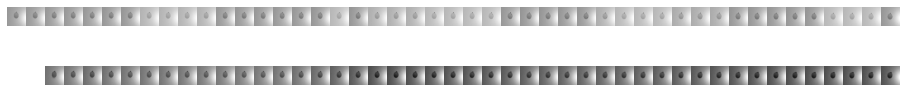

MSE of predictions:  [0.42400038 0.38522232 0.29985    0.64030766 0.772234   0.55848986
 0.81522185 0.45475727 0.45207527 0.59865505 0.26638672 0.2584669
 0.90442604 0.78955525 1.0840629  0.43763927 0.5564227  0.2563907
 0.25341117 0.2539933  0.7016874  0.8459717  0.8228568  0.53403175
 0.40915903 0.27592897 0.28080812 0.28478298 0.8677794  0.5360228
 0.8299077  0.5527061  0.4298018  0.29897195 0.30428067 0.7642073
 0.603186   0.45319462 0.5746659  0.45721626 0.47514832 0.3660655
 0.38264444 0.8602135  0.5410325 ]


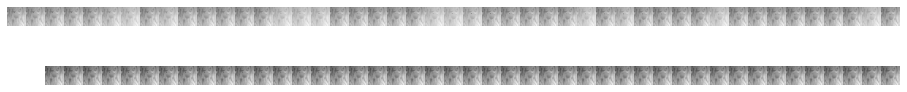

MSE of predictions:  [0.70302933 0.37191463 0.67211974 0.69221693 0.6994231  0.3122357
 0.63086575 0.3136343  0.7139346  0.7114043  0.6480334  0.49917355
 0.5085245  0.70386076 0.7084255  0.69313973 0.41086066 0.44836736
 0.35505676 0.7608256  0.7644484  0.7569204  0.46407264 0.46835357
 0.34577554 0.783778   0.79612863 0.474132   0.45988438 0.45613647
 0.35954356 0.7619576  0.787214   0.4517944  0.46398956 0.47736478
 0.39115494 0.81059206 0.51438844 0.5329715  0.5482211  0.46000654
 0.9016929  0.92813385 0.5996729 ]


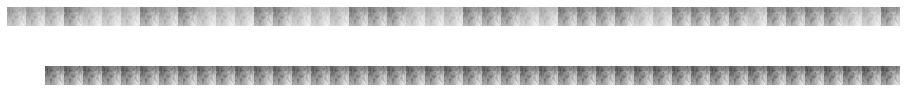

MSE of predictions:  [0.5760665  0.5625138  0.3247909  0.24205875 0.23283282 0.5996732
 0.27005422 0.24157797 0.3245336  0.2998302  0.68541324 0.70686024
 0.3787526  0.33103457 0.37457222 0.40254202 0.8694088  0.5369592
 0.5700172  0.5027725  0.4872723  0.5919067  0.6284346  1.0767276
 1.0791438  0.71047986 0.6678348  0.7700794  0.81390023 1.286454
 0.88557446 0.98127323 1.0569106  1.0527427  1.5533752  1.253744
 1.3516968  1.2739816  1.2747558  1.3066933  1.3691905  1.5169324
 1.5666909  1.446548   1.4136554 ]


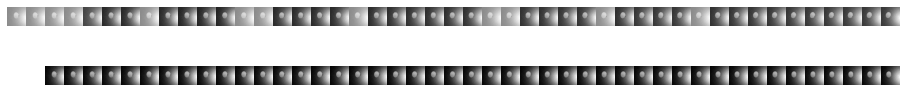

MSE of predictions:  [0.60065377 0.4550507  0.89397305 0.7114877  0.45261928 0.46629706
 0.46806234 0.36535367 0.448212   0.44825655 0.860934   0.84258455
 0.63631487 0.53441954 0.5575242  0.6897924  0.63729566 0.6117748
 0.64123577 0.6928346  0.55505466 0.73410714 1.2133157  1.2376165
 1.1116096  0.77173764 0.7846978  0.7914009  1.0794699  1.2046933
 0.8331666  0.8338941  0.6338636  0.67742777 0.9048058  1.4234488
 1.0952036  1.3362458  1.0189925  1.0450386  1.0659306  1.3944032
 1.5180956  1.1816603  1.2091315 ]


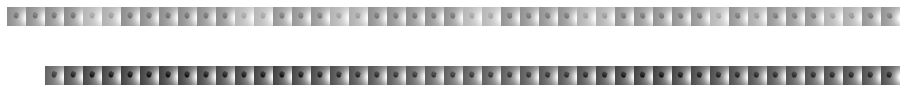

MSE of predictions:  [0.6070308  0.26396477 0.65582967 0.19192465 0.19837806 0.2153848
 0.15035221 0.1826307  0.2527838  0.3687752  0.2743753  0.27400744
 0.28442022 0.2919547  0.20982102 0.23730749 0.32408237 0.3274209
 0.32523274 0.34773725 0.3673561  0.4128328  0.2845639  0.38013065
 0.36937514 0.38334754 0.4814561  0.38725623 0.4038011  0.40562212
 0.401622   0.43016386 0.45285136 0.64689577 0.43228137 0.5283916
 0.567565   0.5991258  0.6283487  0.68021166 0.81400204 0.8630589
 0.6550118  0.7912479  0.80030197]


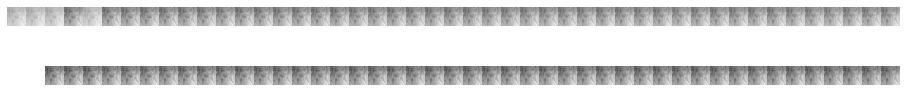

MSE of predictions:  [1.0714817  1.0540824  1.1388252  0.66276026 0.682539   1.0466002
 1.0216863  0.74739075 0.65623534 0.6847263  0.6705084  0.60896355
 0.7377707  1.2777869  0.8921063  1.012735   1.020364   1.0886078
 1.0654458  1.1041756  1.3506773  1.1621482  1.1204189  1.2869829
 1.3436179  1.3267757  1.3816005  1.8894988  1.1689972  1.2419456
 1.2098203  1.3006612  1.4422204  1.3883119  1.3814937  1.513166
 1.746681   1.7763135  1.7661414  1.8207417  1.9213195  2.397341
 2.0209322  2.226233   2.5004442 ]


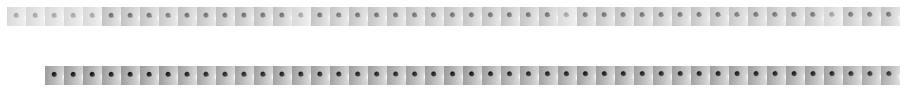

MSE of predictions:  [0.61264384 2.3953211  0.7004285  0.8038271  0.43999678 0.5800182
 0.7772629  1.2948668  0.97234005 0.74780446 0.69310707 0.80362386
 0.77839977 0.54843086 0.5584493  0.55988485 0.46353045 0.5873969
 0.8551114  1.0387217  1.4522946  1.1078511  0.9070288  1.5725212
 1.4364779  1.4533582  1.2519354  1.3181281  1.4228793  1.3691947
 1.5664523  1.976714   2.0208116  2.2473989  2.0492017  2.028552
 2.6844206  2.6829906  2.342589   2.214296   2.262036   2.1117787
 2.4299536  2.8986206  3.0102458 ]


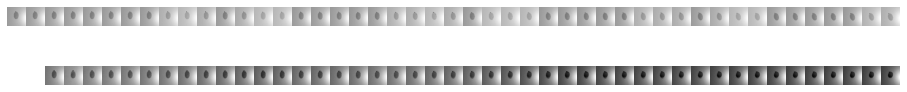

MSE of predictions:  [0.39135745 0.29058456 0.17294441 0.19588858 0.18709922 0.18322594
 0.18473001 0.17892236 0.18897049 0.17497069 0.3320405  0.39441413
 0.34926888 0.23003373 0.26315105 0.21430162 0.22595456 0.21681511
 0.2228837  0.2185243  0.21505618 0.3948329  0.41015628 0.4171601
 0.27600002 0.27045816 0.40220183 0.37266344 0.38294488 0.40505272
 0.28533763 0.28202653 0.2932817  0.50294524 0.5013906  0.341451
 0.28550217 0.30662358 0.27873206 0.26677874 0.25730217 0.2710997
 0.25520635 0.30410188 0.54049814]


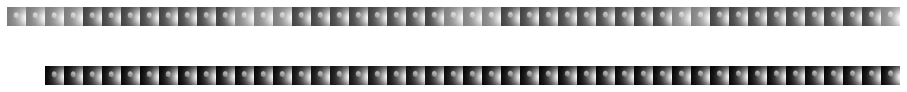

MSE of predictions:  [0.6578769  0.55344564 0.831952   0.878697   0.93814903 0.7556447
 1.0954878  0.96647316 1.1343325  1.3101178  1.8626454  1.8807018
 2.188053   2.3692658  2.2564254  2.4742365  2.3917801  2.2681463
 2.2876787  2.6134076  2.6668916  2.7027714  2.7964962  2.9105544
 3.1117363  3.627758   4.0547857  3.9854026  4.1218176  4.151423
 3.8957849  4.3210435  4.6238327  4.690299   4.8677225  5.110859
 5.2414374  5.7919965  6.233971   6.3301315  6.47898    6.636138
 6.3129363  6.3684826  6.577527  ]


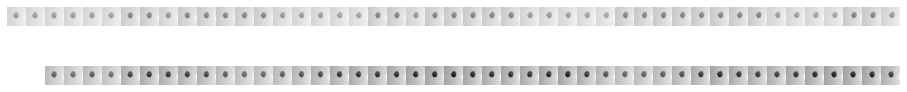

MSE of predictions:  [0.5342564  0.5167755  0.35410133 0.36340204 0.3697752  0.36223307
 0.35585758 0.37702015 0.3747579  0.36778778 0.37548238 0.30117735
 0.81355715 0.3673482  0.3634394  0.35769346 0.38212362 0.38700813
 0.38967454 0.89733964 0.888759   0.857429   0.6738473  0.5245297
 0.26633865 0.42976263 0.4316574  0.4324579  0.28493714 0.44721147
 0.4426949  0.8974831  0.7653479  0.8422377  0.4718489  0.46531677
 0.60712916 0.7782757  0.47023463 0.4675727  0.31718776 0.31509742
 0.3140212  0.4756924  0.47398755]


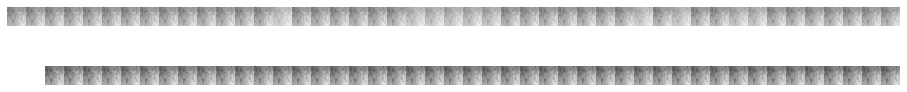

MSE of predictions:  [0.5406474  0.93000484 0.44436115 0.48186857 0.30400515 0.37650776
 0.40988463 0.7810398  0.7975375  0.46561858 0.4170755  0.46004128
 0.44586766 0.44226113 0.48500133 0.43132284 0.42460397 0.43682748
 0.34717143 0.7621296  0.49542058 0.5104518  0.65459657 0.70307904
 0.5394883  0.46639454 0.44559258 0.4989342  0.5045554  0.51396835
 0.86709505 0.54768336 0.5212503  0.46533138 0.42650002 0.44074857
 0.48385084 0.5469591  0.42499545 0.40943852 0.73008657 0.5274967
 0.605288   0.70933044 0.69367063]


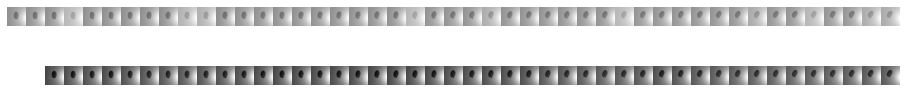

MSE of predictions:  [0.40260124 0.29099888 0.24271971 0.22733018 0.47030017 0.29538292
 0.3017747  0.26130196 0.23515876 0.3682447  0.36924288 0.5078549
 0.36412814 0.34506184 0.3740055  0.5238664  0.4897176  0.69648254
 0.44933677 0.4373334  0.45985705 0.84397745 0.50670004 0.8104768
 0.53187454 0.5517337  0.9227965  0.72955954 0.73928607 0.58058214
 0.66473484 0.6767816  0.81516343 0.6760729  0.7768724  0.692068
 0.7742764  0.65981746 0.7793938  0.7440117  0.7820414  0.7015459
 0.7227956  0.73158836 0.8728882 ]


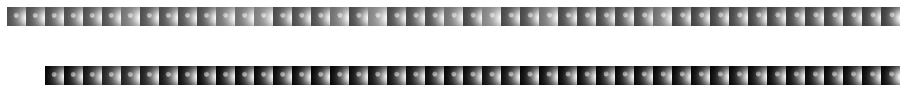

MSE of predictions:  [0.551851   0.49168554 0.36047417 0.42670262 0.23482144 0.24545813
 0.23083532 0.24281538 0.29289496 0.28831896 0.26144174 0.2865712
 0.29995695 0.6667393  0.3742859  0.41597426 0.41287315 0.42054135
 0.5139564  0.8978492  0.568632   0.5676862  0.53781396 0.6005967
 0.59335124 0.6217084  0.7309452  0.74972063 0.73609525 0.870602
 0.93237364 1.0007911  1.1465421  1.2611276  1.2561531  1.4139711
 1.4598761  1.4813622  1.6548108  1.7454145  1.7738287  1.8411064
 2.05929    2.0452085  2.0360658 ]


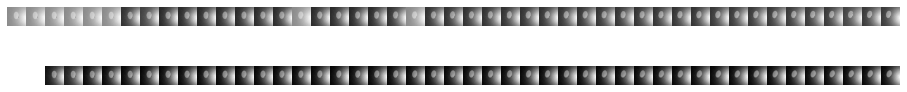

MSE of predictions:  [0.20240684 0.20814651 0.18254848 0.22099632 0.42004064 0.30186716
 0.30237523 0.19962901 0.1922886  0.22907141 0.2779873  0.45986974
 0.37366337 0.38688678 0.6571023  0.46508718 0.45505786 0.49752122
 0.6979461  0.6488104  0.79311574 0.75264436 1.1048343  1.1523247
 0.89817375 0.9238658  1.1801195  0.9762334  1.0368084  0.9328336
 0.9918598  1.4383595  1.6216593  1.1840627  1.3724468  1.3409165
 1.579491   1.2063191  1.2296094  1.2345444  1.7662671  1.7707375
 1.8791021  1.8045772  1.820117  ]


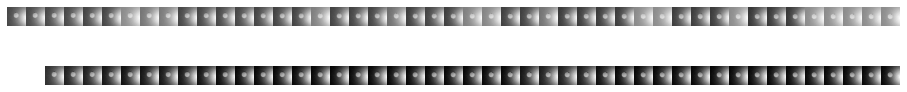

MSE of predictions:  [0.44516003 0.3504048  0.5861717  1.0836916  1.0370479  1.0090632
 0.682444   0.69459355 0.927924   0.98814154 1.381862   1.4492027
 1.0835218  0.80451024 0.84683365 0.9026966  1.1041265  2.0368164
 2.2797375  2.1042898  2.0998266  2.0262587  2.066452   2.1249988
 2.4772406  2.6517193  2.6824396  2.5695996  2.567263   2.583265
 2.2121391  2.853181   2.3988576  2.2965581  2.4067445  2.4279132
 2.1887884  2.2544367  2.9170723  2.4175506  2.608772   2.8590796
 2.8501933  3.608718   3.6928163 ]


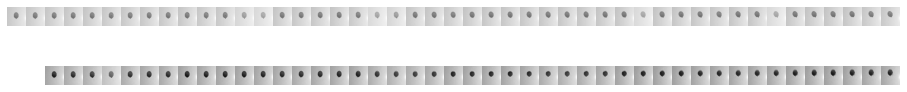

MSE of predictions:  [0.27770987 0.24956824 0.5136179  0.1796715  0.19322985 0.31550282
 0.42636216 0.24460122 0.245065   0.19967452 0.21704048 0.25110877
 0.61927086 0.33555067 0.6985823  0.43176597 0.45067993 0.39784312
 0.4526037  0.46457934 0.62887216 0.6756972  0.69160444 0.67150855
 0.62169296 0.6076733  0.91058785 0.611011   0.650159   0.618474
 0.6776519  0.7272998  0.77609956 0.809922   0.8986068  1.0083495
 1.1551342  1.2800689  1.4010315  1.5374423  1.5801381  1.5944114
 1.5676882  1.6505234  1.7449594 ]


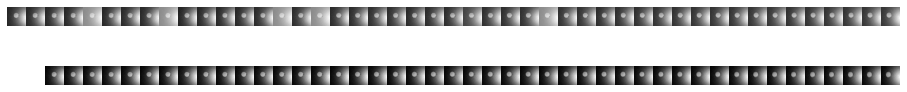

MSE of predictions:  [0.36869758 0.27908066 0.27480444 0.24779062 0.25408944 0.23149821
 0.34418702 0.2933245  0.29674995 0.31342942 0.33271793 0.24565208
 0.39725578 0.30988616 0.3162669  0.33514607 0.32379866 0.2930209
 0.5398712  0.53337926 0.56753564 0.6019684  0.5309149  0.5668299
 0.5518074  0.5488008  0.5107573  0.36570233 0.35742238 0.34865636
 0.33773425 0.5631926  0.69009775 0.711574   0.7299092  0.5159541
 0.36070484 0.31649908 0.31527388 0.32263035 0.329234   0.3326744
 0.5290661  0.53888005 0.55005234]


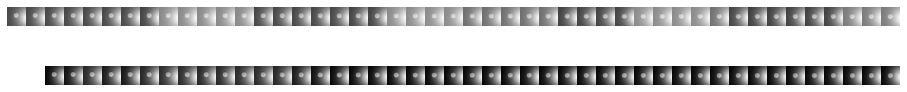

MSE of predictions:  [0.60534495 0.7086708  0.7235228  0.7054429  0.6026218  0.64091575
 0.7512415  0.81674033 1.4673275  1.4731938  1.4413389  0.9046677
 1.5095398  1.3724015  1.4556433  1.6047627  1.5119798  1.5729902
 1.6827923  2.0768704  2.4132495  2.449456   2.6089606  2.6187487
 2.7700112  3.0583227  3.0592587  3.6288798  3.1215272  3.4338298
 4.058991   3.803463   3.772597   3.9350846  4.157381   4.3420787
 4.7574997  5.405566   5.325757   5.3596463  5.6243544  5.730333
 6.347172   6.19862    6.49482   ]


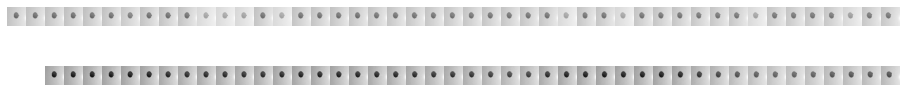

MSE of predictions:  [0.78372633 0.63679457 1.0157143  0.7547215  1.2673572  0.6734164
 0.71323323 0.7360735  0.68719727 1.1075041  0.8711946  0.8534272
 0.88631207 0.92118436 0.91661316 1.0295758  1.0621045  0.9878834
 1.0495853  1.0859587  0.8994908  1.0260897  1.2201136  1.25854
 1.7827556  1.3133221  0.93566895 1.0591267  1.1863363  1.233918
 1.5922322  1.6782217  1.6494621  1.3161459  1.4253993  1.6097839
 1.3254249  1.5544271  1.5556138  2.039695   1.9464631  1.9910154
 1.9313357  2.0310876  2.1231575 ]


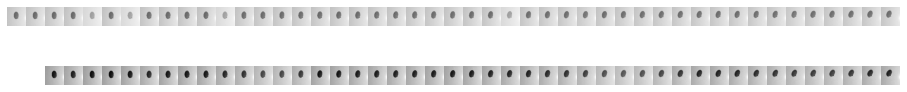

MSE of predictions:  [0.2193292  0.17686321 0.16512829 0.36538592 0.36152613 0.23320395
 0.20704119 0.22515064 0.2049461  0.5127454  0.63360834 0.38977975
 0.29296684 0.45818058 0.39131194 0.67751694 0.6084119  0.35434163
 0.33712846 0.4430932  0.43226805 0.6054857  0.38024122 0.42036057
 0.44817823 0.5560586  0.5143453  0.7042216  0.5748663  0.59098077
 0.7528223  0.7337268  0.7663416  0.9459345  0.76380724 0.793314
 0.8087703  0.8554665  0.90670943 0.9571445  0.91033655 1.1165779
 1.1035526  1.1869032  1.2126085 ]


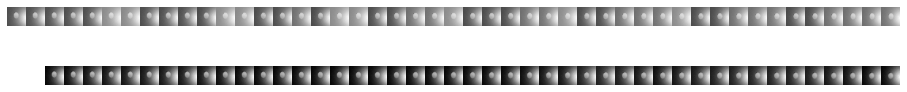

MSE of predictions:  [0.6568341  0.3507114  0.25859886 0.25360623 0.5312814  0.24602315
 0.23478223 0.24765797 0.26515943 0.3774501  0.36348847 0.3288371
 0.51071906 0.29464257 0.3140604  0.33110598 0.34739375 0.5108338
 0.5790211  0.8448857  0.7015051  0.7113136  0.46566275 0.46922174
 0.49965897 0.5110322  0.8932274  0.66124463 0.7122927  0.63607585
 0.6456883  0.6607106  0.66971695 0.9478104  0.73999095 0.800915
 0.8515744  0.7735245  0.8573138  1.1395204  0.8408462  0.89109886
 0.8980314  0.8932459  0.9132012 ]


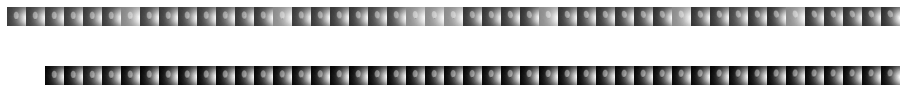

MSE of predictions:  [0.18767877 0.16111264 0.49708566 0.6073468  0.29416054 0.2750034
 0.28098595 0.28276262 0.4507799  0.74426615 0.39757925 0.43876547
 0.440007   0.47550178 0.51422197 0.86590666 0.543331   0.5936986
 0.65265656 0.9511454  0.681367   0.7115689  0.74913764 0.7292845
 1.0097286  0.7751476  0.79415786 1.1113605  0.8336954  0.89824384
 1.1949427  0.96243155 1.0457318  1.5424434  1.5733874  1.4505595
 1.4587212  1.1694927  1.1275413  1.5129919  1.4885818  1.1475182
 1.253718   1.242749   1.1387041 ]


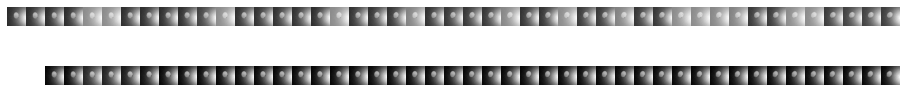

MSE of predictions:  [0.5530261  0.53912616 0.6219426  0.6767442  0.7212057  0.73239315
 0.5982187  0.62890047 0.64793724 0.7431249  0.7153079  0.71555805
 0.7446441  0.77575576 0.84625137 0.85496396 0.7652475  0.8470179
 0.9882954  1.0479404  0.9506201  1.004582   0.889744   0.8825337
 0.82598734 1.3136969  0.9861976  1.069734   1.4777229  1.1714635
 1.2171785  1.6592473  0.97107697 1.0283388  1.6891025  1.6208942
 1.9883024  1.828447   2.0692806  2.1560032  1.5425546  1.5906438
 1.932746   2.707682   3.1235666 ]


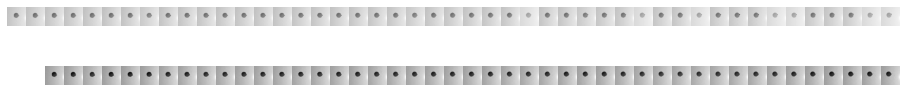

MSE of predictions:  [0.81678253 0.6375794  0.7521528  1.2835457  1.2327707  1.1725723
 1.3766382  1.4578888  1.4762309  1.9358547  2.0695014  2.3583465
 2.2100692  2.0361052  2.3127885  2.1446247  1.7545431  2.0402625
 2.114063   1.717319   1.75811    1.5741149  1.4512895  1.9609975
 1.9060544  2.1023893  1.904936   1.5287443  0.9775738  1.1139396
 1.2035539  1.5201678  1.8281324  2.1421442  2.0599144  1.9713387
 1.5222623  1.4780195  1.5325338  1.5240068  2.4730175  2.7550707
 2.4949932  2.1493976  2.2755032 ]


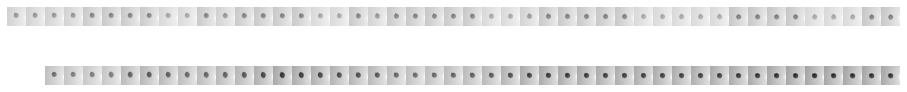

MSE of predictions:  [0.25130448 0.24993959 0.37049642 0.6336098  0.4355897  0.43933982
 0.22915126 0.2121742  0.57259715 0.636837   0.6743564  0.33402294
 0.25562045 0.6248678  0.5952616  0.5852996  0.41466862 0.34645128
 0.3746038  0.72242725 0.6713209  0.6506509  0.9092867  0.8592714
 0.50893724 0.50608015 0.7564636  1.2400501  0.96453243 0.81691575
 0.7570659  1.257744   1.2666645  1.3090556  1.081295   1.1881381
 1.2338034  1.6833138  1.7461898  1.582931   1.6918982  2.213795
 1.8560362  1.917293   2.2920792 ]


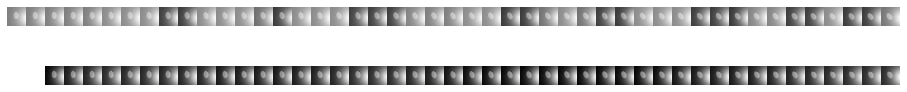

/home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487679_mit_nstep2_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_v_r1.00_kl1.00_lr3e4
MSE of predictions:  [0.15800157 0.09865384 0.5134384  0.571306   0.34138525 0.4250883
 0.66040576 0.6612121  0.94538665 1.0161046  1.5528909  1.2508576
 1.3788807  1.5772257  1.7840748  1.7827764  1.9695294  2.093801
 2.133485   2.3180676  2.4114068  2.5970106  2.90816    2.8740697
 3.1360946  3.2213347  3.2902598  3.5150886  3.6154761  3.7344284
 3.94274    4.1179533  4.242315   4.19261    4.426154   4.5897884
 4.9442835  4.9089093  5.04474    5.086016   5.246074   5.7231174
 5.5139465  5.6910486  5.920803  ]


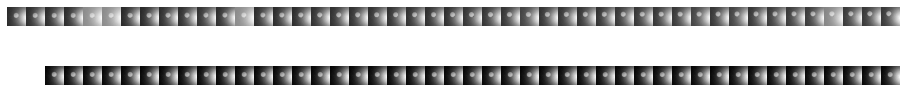

MSE of predictions:  [1.3736018  1.2910352  1.3730816  0.6455601  0.2798444  0.29364198
 0.7659762  0.76861143 0.28763074 0.29398698 0.20225492 0.21551287
 0.66386867 0.3054909  0.31983104 0.33280277 0.24213302 0.2509401
 0.76716727 0.35808733 0.3602698  0.38146234 0.38242173 0.393136
 0.40882927 0.51451784 0.51317203 0.4278202  0.4398204  0.4631403
 0.4649946  0.46317995 0.47160402 0.48081666 0.38992524 0.39997256
 0.50956243 0.5275043  0.54908746 0.43024197 0.44806382 0.46080667
 0.57337034 0.5933189  0.596885  ]


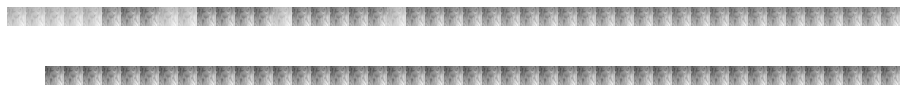

MSE of predictions:  [0.2912441  0.26530766 0.25928298 0.3983778  0.16739541 0.17255194
 0.67725    0.2986172  0.44801903 0.3210543  0.3211731  0.3286405
 0.80805767 0.55800426 0.3248757  0.3306672  0.33735877 0.34231976
 0.81178445 0.8152068  0.819029   0.6832772  0.61329865 0.7174845
 0.37281084 0.38106927 0.38115132 0.28326124 0.28977618 0.39530277
 0.40514833 0.5692156  0.32045195 0.4483781  0.4494112  0.91285205
 0.445018   0.46271205 0.46336174 0.46055806 0.473668   1.0922319
 1.2786845  0.52756065 0.54643536]


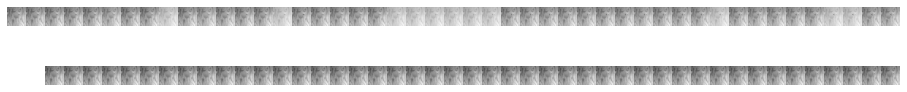

MSE of predictions:  [0.61540955 1.0832368  1.0356606  0.5298966  0.5595108  1.0601369
 0.942565   0.95132804 1.0273914  0.8420365  1.3974984  1.3875885
 0.96904325 1.0807432  1.064174   1.4404715  1.5581763  1.4036007
 1.9999158  1.4683375  1.5078833  1.5786495  2.0753565  1.6919045
 1.7299608  1.827614   2.1668391  2.1903567  2.194078   2.1631095
 2.5049913  2.2876637  2.081552   2.1476543  2.0813475  2.1480327
 2.2422698  2.2691786  2.738301   2.3728104  2.38144    2.4469342
 2.4611607  2.5005894  2.5406728 ]


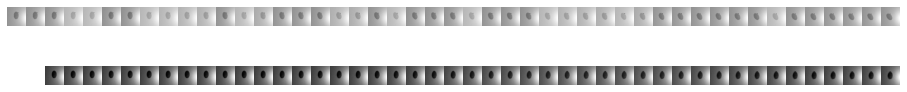

MSE of predictions:  [1.2697095  1.230705   1.2278869  0.91327345 0.97778577 1.6405021
 1.8705627  1.603023   1.8057283  1.8320849  1.9309261  2.026225
 2.9236236  2.635862   2.318849   2.4937     2.6794243  3.116399
 3.2035408  3.2073581  3.2656648  3.364874   3.6701949  4.0207376
 3.866109   4.159413   4.3146524  4.284743   4.5861163  4.647278
 4.6405373  4.6847105  4.786444   5.17614    5.0485435  4.964344
 4.9822893  5.002842   5.178193   5.7870364  5.5150814  5.520316
 5.535206   5.868026   5.9144907 ]


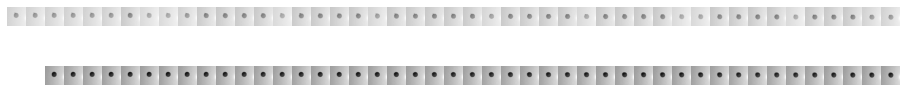

MSE of predictions:  [ 0.7001716   0.6814111   0.397432    0.41707727  0.9217315   0.75480413
  1.0712568   1.1828934   1.4661398   2.1087623   2.6457589   2.6126623
  3.0783925   3.4684806   3.8628306   4.463788    4.745595    5.1232734
  5.493903    5.9558744   6.5158052   7.085083    7.3901863   8.047457
  8.440037    8.997321    9.206014    9.753773   10.136469   10.534165
 10.964994   11.422256   12.086391   13.079287   13.223782   13.505474
 13.94338    14.282742   14.619202   15.262767   15.675583   16.23932
 16.520267   17.002817   17.317991  ]


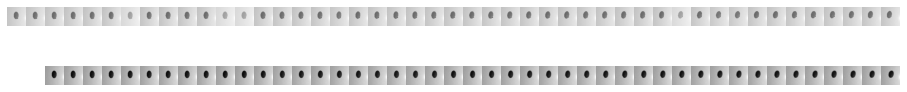

MSE of predictions:  [0.48112938 0.48261058 0.49749637 0.28624478 0.3070212  0.71180207
 0.7642331  0.7927779  0.7886909  0.5857447  0.6268547  0.70807314
 0.8911248  0.9489037  0.7665713  1.2419152  0.9408245  1.3598912
 1.4448494  1.5020701  2.0467205  2.0909185  2.0021505  2.0513697
 1.7482176  1.5471258  1.6150608  1.6757866  1.8317795  2.1970372
 2.5810816  2.6318517  2.6286583  2.3281894  2.2968197  2.335805
 2.2509675  2.1864104  2.2189903  2.2455564  2.2612066  2.778294
 2.818471   2.7175171  2.3800774 ]


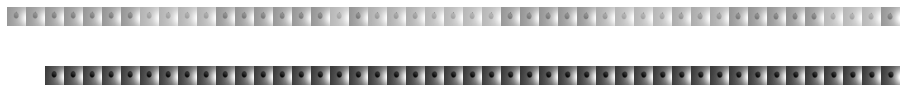

MSE of predictions:  [0.6903261  0.6719914  0.5821642  0.9051238  1.2129729  0.7930839
 1.1147171  0.72585833 0.7314611  0.8672838  0.5676346  0.57986486
 1.3305104  1.1819725  1.4605744  0.74368405 0.9125016  0.61665416
 0.6145483  0.6422803  1.0554711  1.187527   1.1516439  0.899507
 0.79940635 0.69797087 0.72737205 0.7232946  1.3083764  1.0039644
 1.2341653  1.0029461  0.9053706  0.8059703  0.8048202  1.248155
 1.109997   0.9477423  1.070209   0.97152966 0.9827527  0.89071757
 0.9042142  1.3554516  1.043127  ]


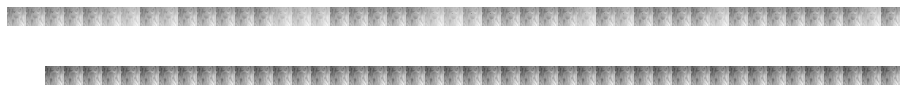

MSE of predictions:  [0.67571235 0.33846602 0.80769646 0.8348124  0.8422192  0.3460424
 0.7856392  0.3682713  0.86649114 0.8761107  0.7390461  0.5504124
 0.56904227 0.91504663 0.92671216 0.8089423  0.47822115 0.5012725
 0.3764478  0.86268926 0.87722385 0.8820803  0.5568029  0.5702441
 0.44065022 0.92987406 0.96063256 0.6261095  0.63108075 0.65232635
 0.53984374 1.0264515  1.0636284  0.7226958  0.7451155  0.73620486
 0.6496123  1.1204218  0.80451834 0.82505095 0.8442472  0.72908527
 1.196941   1.2373948  0.8860229 ]


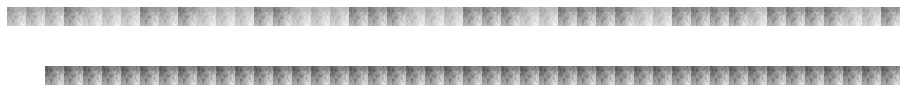

MSE of predictions:  [0.68981236 0.6110054  0.4169367  0.3387522  0.44605437 1.0368147
 0.66592556 0.69768226 0.8685202  0.9022751  1.4101111  1.5441561
 1.2538007  1.2500427  1.4172807  1.4815173  2.0337462  1.7810041
 1.9008619  1.8871938  1.8776972  2.0325706  2.165778   2.733451
 2.8094988  2.466918   2.517834   2.7126372  2.7945328  3.3192081
 2.9379942  3.048938   3.1572924  3.17037    3.7001445  3.4457266
 3.5533974  3.558117   3.6014264  3.750916   3.8665752  4.096093
 4.3029575  4.271502   4.3045387 ]


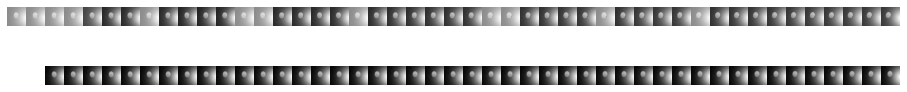

MSE of predictions:  [0.5858924  0.46270978 1.0895299  0.8464174  0.4879069  0.5266704
 0.5873023  0.41524905 0.6189481  0.6567635  1.1881355  1.1911185
 0.95781356 0.8166184  0.83075154 1.0858006  1.0323877  0.8293897
 0.85177    0.90348643 0.76904595 0.9266296  1.3645136  1.4241616
 1.2453022  1.0292629  1.0373667  1.0342444  1.3440015  1.4430876
 1.1270142  1.1505042  1.0253942  1.0593679  1.2020814  1.6794761
 1.333839   1.5070419  1.2254906  1.2309093  1.257317   1.5185889
 1.5833004  1.2610962  1.2618294 ]


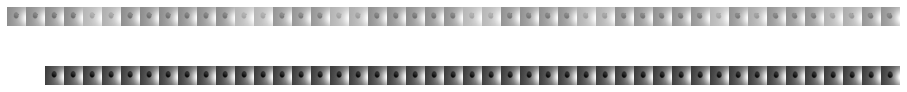

MSE of predictions:  [0.65300196 0.2934783  0.795932   0.27324265 0.27519694 0.28243235
 0.16696866 0.18589807 0.2917116  0.40459397 0.30509382 0.29660088
 0.30663985 0.3131873  0.2165372  0.25177836 0.35682198 0.36910415
 0.37488562 0.38653195 0.4240505  0.47340053 0.32287914 0.44050115
 0.44545758 0.4754663  0.5934789  0.48492157 0.50995505 0.5212172
 0.5244025  0.53521633 0.55512905 0.749823   0.5106216  0.60958177
 0.63204956 0.6493499  0.65595484 0.68555987 0.8224648  0.86018115
 0.6152366  0.7407656  0.7397275 ]


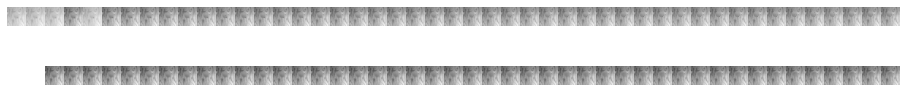

MSE of predictions:  [1.1414055  1.1439493  1.1356267  0.6953969  0.79142314 1.3496664
 1.316942   1.2146426  1.093717   1.3309394  1.455885   1.4475875
 1.5056772  2.096481   1.6451067  1.8137276  1.8031372  1.9659164
 1.9078007  2.0406861  2.4885805  2.3848925  2.3762078  2.6035945
 2.7920213  2.8536823  2.9550586  3.4254932  3.0794914  3.2068663
 3.3864248  3.5105166  3.7772822  3.7998674  3.9458377  4.064566
 4.289622   4.2772713  4.465434   4.5906367  4.679697   5.050767
 4.835343   5.071651   5.364759  ]


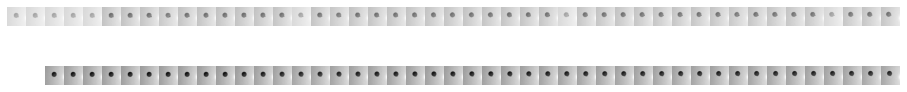

MSE of predictions:  [0.57770455 0.5189357  0.5176871  0.5470322  0.33280832 0.5880474
 0.90846133 1.4285586  1.1442482  0.8342952  0.7741058  0.9070597
 0.93393713 0.65458393 0.7020762  0.7157627  0.553836   0.7070447
 1.060868   1.2064021  1.7194076  1.1500964  0.81741786 1.5516369
 1.2343924  1.2264111  0.9666315  0.9807276  1.0756665  0.9204261
 1.11198    1.5561879  1.5796635  1.831969   1.5096203  1.477511
 2.1385803  2.0036695  1.6853395  1.6654539  1.7556511  1.5809984
 1.9307828  2.44846    2.4997776 ]


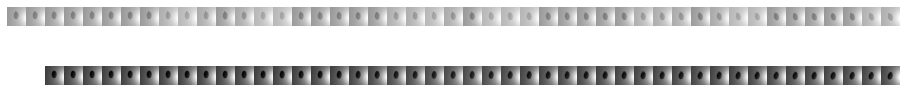

MSE of predictions:  [0.3465305  0.33760548 0.24673742 0.26428518 0.22243257 0.23690814
 0.30862093 0.3311916  0.37667608 0.40947944 0.7302841  0.8791143
 0.8797691  0.8023864  0.9834846  0.96966326 1.0407214  1.1194103
 1.2851871  1.4370788  1.557014   2.0050383  2.1497703  2.214489
 2.0673256  2.1806772  2.2936246  2.2810965  2.3616765  2.4416103
 2.589711   2.6568913  2.7331576  3.107864   3.145955   3.00798
 3.0847569  3.2348402  3.3296342  3.3960953  3.4558575  3.534723
 3.5751266  3.6910713  4.1047745 ]


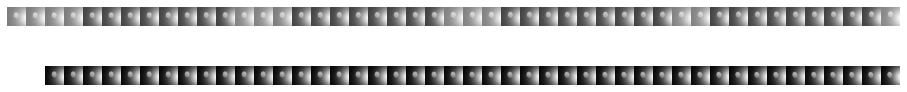

MSE of predictions:  [1.8778272 1.7113572 1.6164696 1.7785721 1.3558815 1.2388113 1.5317216
 1.274605  1.4180678 1.4442247 1.5483315 1.4720238 1.8070234 2.1338482
 1.8594567 2.110148  1.9316291 1.5687228 1.6045533 1.8865281 1.973707
 2.054073  2.007542  1.999478  2.074217  2.569435  2.9142077 2.713543
 2.7742724 2.679843  2.4173393 2.7809477 2.9373763 3.0336883 3.181283
 3.2001708 3.2551172 3.6546326 4.0563335 4.080125  4.2955246 4.46598
 4.212385  4.356665  4.5746665]


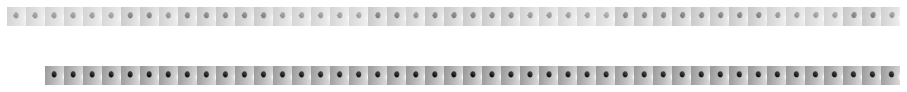

MSE of predictions:  [0.4725938  0.46941984 0.30873778 0.34444505 0.33668622 0.34248388
 0.33899212 0.35776713 0.36084005 0.3622444  0.37632567 0.29491568
 0.8074936  0.3731863  0.38086748 0.3790291  0.39596835 0.39354587
 0.3964451  0.9172088  0.8993548  0.87204075 0.6925354  0.543898
 0.2766339  0.43445507 0.4290586  0.43374354 0.28749454 0.4343338
 0.428769   0.85580856 0.71338797 0.7906816  0.4394731  0.43885326
 0.5830037  0.7368017  0.45400828 0.45185876 0.3160637  0.31896508
 0.31667107 0.46806556 0.46714675]


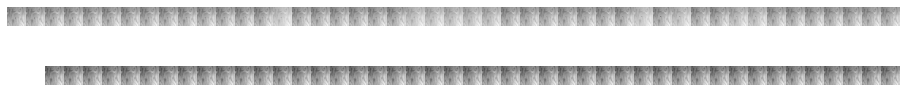

MSE of predictions:  [0.5332573  0.96183026 0.40902472 0.4413401  0.30202276 0.33626148
 0.4203773  0.8125689  0.9148711  0.6187466  0.579352   0.6110704
 0.6051751  0.66417646 0.73975956 0.7231724  0.74094844 0.7798655
 0.6603985  1.1664761  0.878844   0.9299531  1.1780927  1.2410715
 0.98901814 0.9759629  0.9956441  1.0906949  1.1150683  1.203098
 1.5927795  1.3277494  1.3696811  1.4043835  1.3752654  1.4931219
 1.6188569  1.757622   1.5530984  1.5605834  2.0239468  1.8317546
 1.9791404  2.0792909  2.0988398 ]


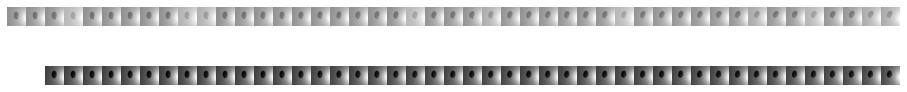

MSE of predictions:  [0.21699989 0.16093546 0.15624312 0.2186243  0.5599654  0.4393018
 0.5982019  0.7007412  0.76582706 1.1085538  1.2084222  1.389292
 1.2870185  1.401803   1.5245633  1.8622448  1.8795104  2.2867815
 2.0043764  2.1201549  2.2650971  2.7821147  2.502397   2.899839
 2.672607   2.8174877  3.2593222  3.1922293  3.3261964  3.3601067
 3.508388   3.6713114  3.9446251  3.9379177  4.018166   4.044459
 4.25068    4.1861143  4.3538785  4.390529   4.5225067  4.5142527
 4.654582   4.7619734  4.987013  ]


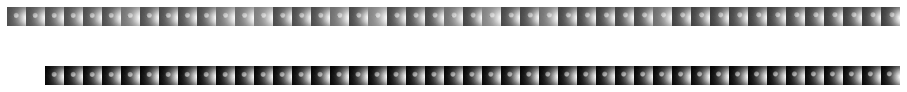

MSE of predictions:  [0.9852925  0.89583516 0.5289922  0.53545874 0.30588955 0.4078163
 0.38017404 0.43560845 0.55498743 0.6022204  0.55493116 0.6817325
 0.7426421  1.2579932  0.92333853 1.0041733  1.0152701  1.063167
 1.2212939  1.7513914  1.4669017  1.5174322  1.5258138  1.6529601
 1.7039043  1.7762982  1.8651023  1.9456427  1.9174893  1.9940796
 2.0638182  2.174578   2.3448627  2.476329   2.44808    2.6453466
 2.748105   2.7904606  2.9965913  3.0027964  3.0247254  3.0877006
 3.3113918  3.2827141  3.303751  ]


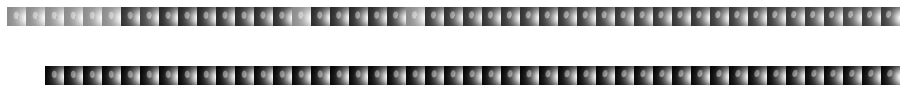

MSE of predictions:  [0.13922219 0.1373258  0.1596914  0.27891254 0.66780925 0.5680561
 0.6073406  0.479119   0.47902203 0.54353446 0.64613616 0.89113986
 0.8512167  0.9021617  1.162608   0.9935976  1.0148655  1.0991769
 1.39767    1.3211802  1.4078492  1.4392327  1.7788718  1.8471456
 1.576665   1.626375   1.921369   1.7169324  1.8043597  1.756475
 1.8566475  2.3206465  2.4740646  2.1582117  2.341201   2.3164313
 2.5323956  2.2103086  2.2387562  2.2650275  2.703785   2.7181053
 2.7713466  2.769023   2.8172386 ]


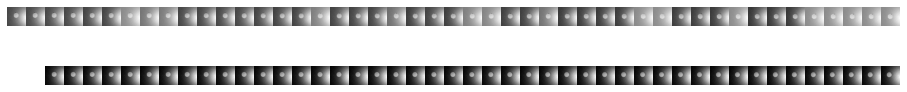

MSE of predictions:  [0.7388018  0.7284991  0.7208068  0.72498155 0.9123477  0.8670696
 0.79490745 1.0386107  1.455992   1.5744188  2.0667868  2.1751628
 1.8905951  1.6898122  1.8956274  2.0366263  2.4018264  3.2927475
 3.3448648  3.1435452  3.0976155  3.2601879  3.4106956  3.6251364
 3.853303   4.091794   4.140041   4.09307    4.427118   4.5186763
 4.644061   5.0738516  4.859092   4.978684   5.1031184  5.12398
 5.240179   5.446926   5.847659   5.8056912  5.8192377  5.8740735
 5.89973    6.2391415  6.490369  ]


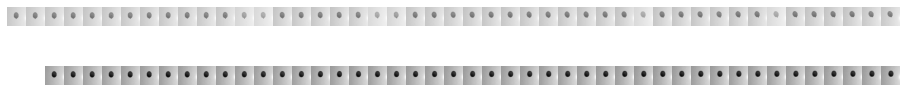

MSE of predictions:  [0.16456297 0.15378624 0.50398064 0.1440043  0.21592557 0.33726573
 0.8462087  0.45231166 0.5152539  0.5246602  0.55241627 0.5820347
 1.2076372  0.87610483 1.4586613  1.086834   1.1649305  1.2091856
 1.24078    1.3195443  1.4290626  1.5083519  1.6098547  1.6683491
 1.7143595  1.8213739  2.3430285  2.0136087  2.0725312  1.8800657
 1.9344274  1.9897621  2.1974711  2.2450798  2.270765   2.2835836
 2.3178298  2.3579752  2.3724265  2.3231719  2.4407983  2.519537
 2.528168   2.568285   2.595281  ]


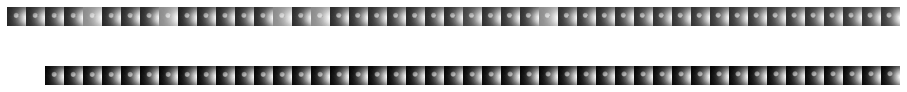

MSE of predictions:  [0.17947553 0.1382844  0.17386375 0.20145899 0.22424495 0.2260878
 0.6009074  0.6318723  0.62481666 0.64675105 0.72584385 0.45382702
 0.6368985  0.50127584 0.58172435 0.63897383 0.62765193 0.7015108
 1.1142433  1.1676714  1.1779513  1.2085111  1.1424482  1.1976917
 1.2291714  1.357795   1.3679577  1.2862389  1.3533387  1.4295448
 1.4576116  1.8892702  2.1545978  2.1793456  2.2268128  2.003108
 1.8707964  1.8233311  1.8576849  1.883209   1.9213545  2.004875
 2.3849983  2.4372478  2.4874578 ]


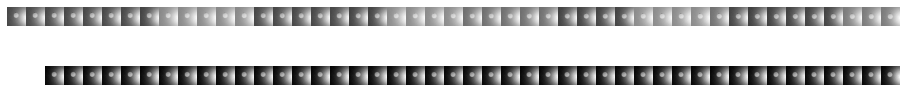

MSE of predictions:  [0.6756016  0.6920449  0.6547671  0.68189204 0.9734989  1.1724542
 1.4007246  1.506238   2.1779978  2.1296387  1.9042606  1.4216168
 2.0701969  1.9592115  2.1682944  2.314884   2.1897368  2.3547924
 2.4492345  2.916244   3.153797   3.1360354  3.2784567  3.2711906
 3.4109964  3.7275972  3.8040764  4.4556384  4.0526314  4.429758
 5.030015   4.7149105  4.6624327  4.777896   4.9590964  5.1795673
 5.551104   6.1282587  5.941198   5.8832846  6.1408405  6.21171
 6.83479    6.6523433  6.9168377 ]


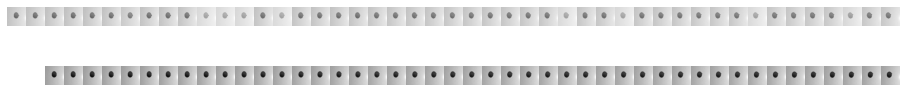

MSE of predictions:  [0.41587391 0.411015   1.0848434  0.8510618  1.645195   1.2826772
 1.4405019  1.6359358  1.445446   1.8419058  1.6227036  1.726325
 1.8307219  2.1052136  2.2859004  2.9657617  3.0950885  3.399782
 3.4971113  3.6597528  3.9655495  4.10345    4.741588   5.012887
 5.6789446  5.3380947  5.3208046  5.620212   5.938024   6.1583805
 6.348835   6.7561536  6.9110065  6.9662666  7.3011165  7.6908064
 7.732055   8.0446     8.146999   8.874455   8.929235   9.056579
 9.127521   9.463049   9.591344  ]


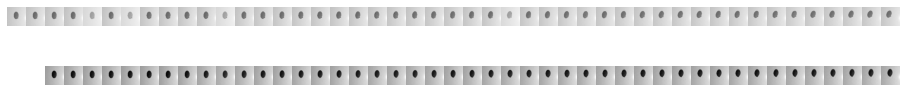

MSE of predictions:  [0.17744468 0.157967   0.1898627  0.544193   0.52761745 0.4359774
 0.4326827  0.53218204 0.5999674  1.1150582  1.3597667  1.1034441
 1.1274017  1.5468408  1.3989215  1.8776352  1.8972142  1.6763172
 1.784592   2.1663287  2.1410737  2.3749855  2.173041   2.2525966
 2.2951643  2.5482702  2.7298992  2.9608614  2.7245498  2.7363338
 3.058205   2.990242   3.032367   3.46167    3.247654   3.2615316
 3.3178144  3.383505   3.4132018  3.3207755  3.3446949  3.6525986
 3.5894985  3.5959275  3.6383998 ]


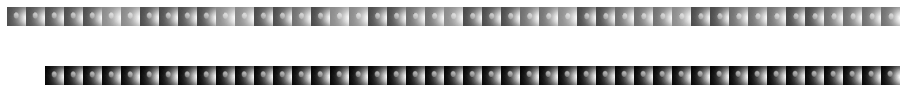

MSE of predictions:  [0.23278087 0.18013377 0.16244096 0.15526402 0.5926201  0.26319766
 0.30040336 0.3313313  0.36954618 0.60903645 0.6401609  0.66498196
 1.2941611  0.91136813 1.0494108  1.1140774  1.2299529  1.4849145
 1.6840581  2.4342484  2.3859472  2.3991508  2.0698824  2.1014512
 2.2105048  2.3090487  2.8466678  2.679737   2.8832445  2.7847912
 2.8982546  2.9373066  3.0700705  3.5983784  3.3261557  3.4529104
 3.630815   3.65003    3.73764    4.15849    3.7803998  3.9479992
 4.0208826  4.0978956  4.2544184 ]


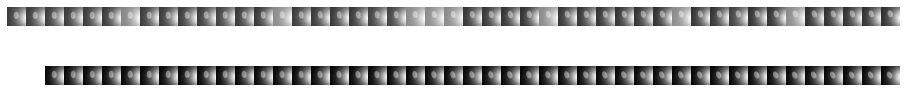

MSE of predictions:  [0.1555446  0.15398233 0.49787408 0.5624542  0.24153109 0.29097164
 0.32309383 0.36422753 0.50984573 0.82953095 0.45976508 0.49473852
 0.54313684 0.53361166 0.52669746 0.97307515 0.5993351  0.6015241
 0.59767586 0.9365927  0.6270199  0.6621722  0.65462685 0.70041263
 1.0181217  0.7232373  0.71625614 1.0823009  0.7637123  0.75964344
 1.0817275  0.7424381  0.74665797 1.2164884  1.2259145  1.0308738
 1.0824416  0.76523876 0.71009994 1.132449   1.141366   0.83286446
 0.9673722  0.98153484 0.7717992 ]


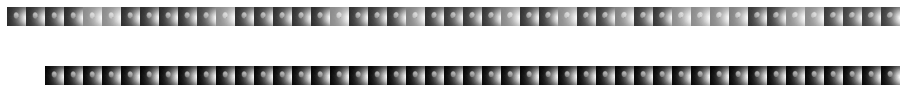

MSE of predictions:  [0.68648577 0.6690881  0.6674327  0.66148925 0.662244   0.9037939
 0.96561134 1.0527681  1.2436869  1.1334765  1.0354445  1.0688298
 1.0378821  1.0329138  1.166312   1.2932537  1.2130327  1.3877709
 1.5125054  1.5603143  1.504413   1.5056186  1.6545227  1.6919096
 1.6075437  2.1133535  1.7783355  2.0379324  2.389223   2.0391204
 2.0665014  2.5370626  2.3277245  2.2963884  2.8702884  2.6897554
 2.8121107  2.6211948  3.127615   3.1731267  2.7954664  2.8311062
 2.9636538  3.5403953  3.739439  ]


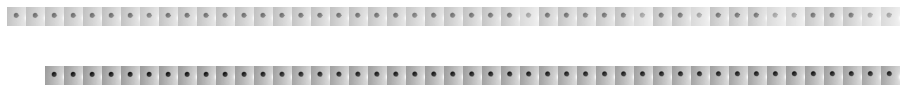

MSE of predictions:  [1.2389232 1.2252555 1.2232134 1.0480771 1.1757256 1.1231703 1.6637448
 1.6124338 1.489321  1.7898908 1.6891364 1.4540992 1.6850363 1.4863101
 1.8902421 1.9568042 1.8259104 2.2220125 2.380453  2.183117  2.3384898
 2.1887808 2.345894  2.8934634 3.1425672 3.2198553 3.2248826 3.0577674
 2.8411324 2.9604278 3.1986651 3.4762697 3.7692604 4.091538  3.8767078
 3.880005  3.6873317 3.6825688 3.7989116 3.7222567 4.449221  4.6289687
 4.338361  4.0391316 4.1978755]


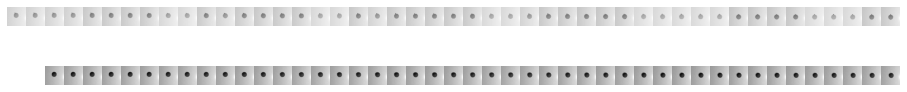

MSE of predictions:  [0.32179058 0.3323662  0.45972228 0.87555975 0.64881665 0.68350196
 0.4178189  0.46507406 1.1967292  1.3155077  1.4198608  0.93720794
 0.8049871  1.27719    1.2387909  1.3110056  1.1711149  1.1686472
 1.2479722  1.6122653  1.6464081  1.7035635  1.9928164  2.0174994
 1.6988199  1.7581966  2.0448818  2.5989676  2.403216   2.2347448
 2.200901   2.7133005  2.678307   2.7497725  2.521914   2.6344962
 2.6739213  3.1005812  3.1538808  3.013975   3.1193757  3.6252337
 3.3234868  3.4127069  3.7754729 ]


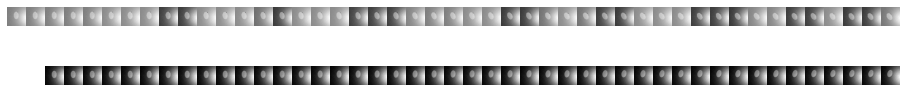

/home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487685_mit_nstep2_1024optbase_noAnnealkl_noWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vh_r1.00_kl1.00_lr3e4
MSE of predictions:  [0.3567382  0.4149021  1.5975952  1.9622985  1.5889764  1.4603565
 1.3605388  1.2535617  1.200409   1.0345964  1.3749096  1.0179727
 0.9662173  0.9094546  0.9238908  0.84087205 0.8529092  0.8790583
 0.80537844 0.8729383  0.84010017 0.8282236  0.99862343 0.9451463
 1.007454   1.1229945  1.0299075  1.1639423  1.1903499  1.2049607
 1.3160998  1.3763285  1.457547   1.4388119  1.6574786  1.7116969
 1.9666773  1.868309   1.9298831  1.9881996  2.0935287  2.5035603
 2.2780814  2.4034626  2.5936792 ]


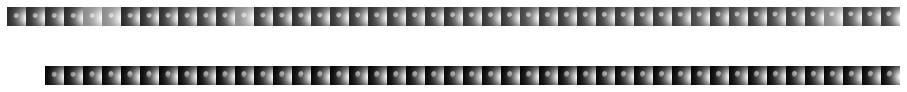

MSE of predictions:  [1.3024904  1.2969861  1.3891989  0.67549324 0.33627734 0.44241244
 0.92470753 0.95218384 0.4598676  0.4610594  0.384962   0.41479108
 0.8940011  0.54222196 0.5465876  0.5583477  0.450132   0.4561854
 1.028569   0.5825499  0.58424973 0.601743   0.6159746  0.619403
 0.6292361  0.7614637  0.7604586  0.6494926  0.662264   0.6742159
 0.6729865  0.6654971  0.6530973  0.6582533  0.5457717  0.54424536
 0.67381763 0.68006617 0.68554294 0.5488827  0.5504947  0.56400216
 0.6942358  0.7160829  0.7026511 ]


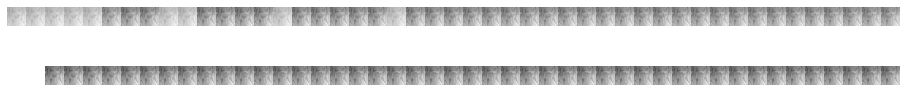

MSE of predictions:  [0.29176402 0.25966296 0.25686258 0.4171321  0.20745586 0.21814618
 0.7084354  0.3328258  0.4756162  0.3517674  0.36084148 0.36877295
 0.8769401  0.6341857  0.3998766  0.4104823  0.42375433 0.44265965
 0.9644965  0.98120606 0.99794257 0.8638604  0.80442744 0.9121691
 0.5684575  0.5786755  0.5910111  0.48402578 0.4965539  0.63613105
 0.65638685 0.8385062  0.5748439  0.7128854  0.71099275 1.1740954
 0.69734323 0.70775425 0.7162527  0.71847034 0.7247288  1.3366032
 1.5360972  0.76290244 0.7828456 ]


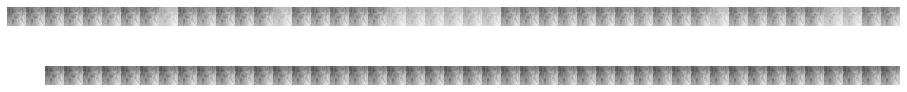

MSE of predictions:  [0.58933496 1.0845461  1.0727203  0.5756944  0.61258674 1.0868089
 0.9504429  0.9466617  1.004176   0.81446993 1.327005   1.3083854
 0.866025   0.9435712  0.90517306 1.2479138  1.3539174  1.1948459
 1.7342466  1.1838387  1.1896657  1.2239511  1.7195162  1.351593
 1.3610663  1.453327   1.8101256  1.8310773  1.8369873  1.8320091
 2.2337556  1.9697928  1.7076187  1.7680303  1.7150279  1.7700644
 1.9104257  1.943876   2.4389489  2.064912   2.10067    2.1662903
 2.236127   2.327419   2.346248  ]


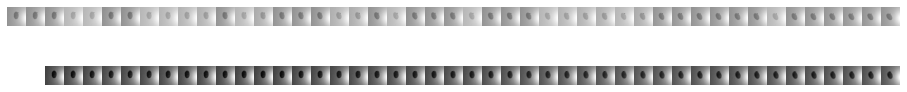

MSE of predictions:  [ 1.5764096  1.3431103  1.353243   1.1661161  1.2222805  1.9754902
  2.2906556  2.0632627  2.2155318  2.399696   2.6584647  2.956381
  4.026621   4.0285044  4.347957   4.89864    5.2924767  6.0766087
  6.1482487  6.3923397  6.5969186  6.935936   7.5082655  8.144121
  8.005671   8.423842   8.8493395  9.114444   9.549604   9.797298
 10.029109  10.451008  10.935738  11.739486  11.852769  11.922323
 12.192331  12.324484  12.586668  13.312889  13.310036  13.591515
 13.819429  14.258026  14.535063 ]


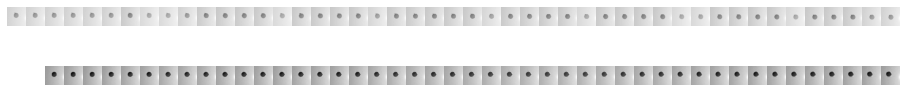

MSE of predictions:  [0.62693727 0.62366533 0.34846961 0.38258445 1.0365503  1.0582298
 1.259985   1.4003456  1.363374   1.8747818  2.050924   1.8217332
 2.0806208  2.0253305  2.264584   2.785434   2.903552   3.2267528
 3.4649882  3.2225285  3.1629376  3.4646828  3.4836006  3.8356075
 3.5760076  3.65774    3.8366866  4.3788347  4.364114   4.498539
 4.3973064  4.795079   4.5960326  5.081136   4.89925    5.1786194
 5.2206125  4.9332123  4.8364115  4.9820004  4.8819847  5.0779843
 5.166561   5.2514343  5.4197035 ]


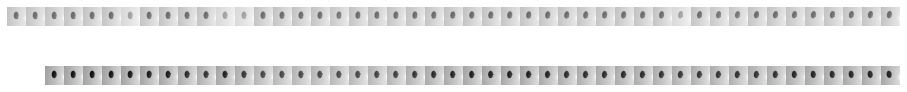

MSE of predictions:  [0.73903525 0.6123728  0.6841147  0.49108535 0.49071702 0.8055351
 0.85097146 0.87727815 0.8776234  0.6576683  0.67407906 0.6660056
 0.81559587 0.82187307 0.60961854 0.8132431  0.5579457  0.92557013
 0.9703401  1.0961089  1.2850353  1.3480158  1.1694837  1.1897568
 0.95799685 0.5887845  0.6136142  0.6124309  0.8013797  1.1213655
 1.4006877  1.4568127  1.500423   1.2386289  1.0236843  1.0633599
 0.91448474 0.68160623 0.76025945 0.7988044  0.8296749  1.2514877
 1.2835393  1.1195735  0.83115983]


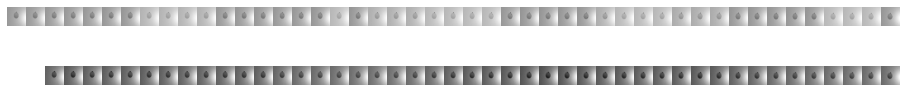

MSE of predictions:  [0.39464104 0.37834048 0.26982582 0.64292854 0.98965484 0.50863725
 0.8588839  0.49747863 0.51732075 0.6696999  0.40533245 0.43483558
 1.1699144  1.045331   1.334928   0.63270366 0.8145548  0.5614408
 0.5697713  0.60911024 1.0343702  1.1745825  1.1561544  0.9194042
 0.8264164  0.7311579  0.761595   0.75747776 1.3460274  1.0388367
 1.3037586  1.0637422  0.95345044 0.8458426  0.8450187  1.3073652
 1.1734097  0.9957832  1.1243904  1.0138961  1.0237027  0.9210336
 0.935601   1.4074862  1.0834045 ]


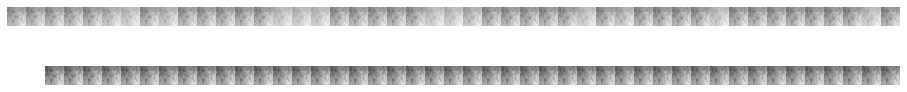

MSE of predictions:  [0.6684962  0.37931323 0.81480765 0.8420906  0.81543523 0.3844515
 0.76977503 0.36165565 0.7744304  0.7869075  0.6791435  0.5168218
 0.5189716  0.7632134  0.7681167  0.668354   0.36326718 0.38363606
 0.25356054 0.6874004  0.70533    0.7085019  0.40122664 0.41473573
 0.3010207  0.7469393  0.7667344  0.4557594  0.4582212  0.46823305
 0.36739153 0.77749836 0.80722183 0.4785816  0.49449277 0.5007781
 0.42049235 0.79222035 0.5190912  0.5362346  0.5485951  0.459022
 0.85877347 0.89799964 0.5728314 ]


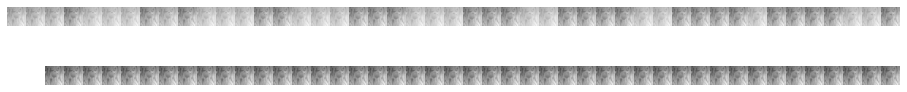

MSE of predictions:  [0.7749978  0.7091824  0.43805137 0.3358394  0.4036659  0.9645646
 0.5730552  0.56956035 0.7259632  0.7638281  1.29495    1.413605
 1.1373636  1.1502677  1.3285472  1.4426534  2.037585   1.7915841
 1.9609305  1.9626598  1.9292706  2.086012   2.2050827  2.7505352
 2.8301482  2.3811767  2.349066   2.515043   2.5646498  3.1049435
 2.6577482  2.7076392  2.7729642  2.7651818  3.2704208  2.9773498
 3.0865855  3.0263417  3.0688953  3.1862602  3.3021536  3.5129743
 3.6874554  3.6478262  3.6946576 ]


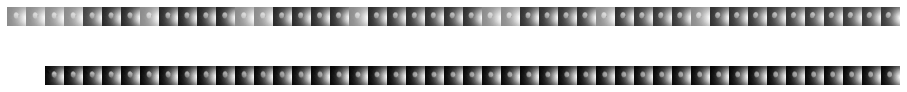

MSE of predictions:  [0.58542717 0.54929227 1.0784998  0.7520442  0.51834524 0.5448183
 0.56048304 0.41818023 0.6224737  0.63311166 1.1309047  1.1642133
 0.9167232  0.759636   0.78560024 1.0014557  0.9402702  0.7484298
 0.7667166  0.8059299  0.6434034  0.8006706  1.3397545  1.3604803
 1.1767412  0.81315225 0.81408584 0.81336635 1.0990773  1.2012931
 0.85054725 0.8996048  0.8330505  1.0909541  1.3717754  1.745666
 1.3497882  1.4685874  1.1800525  1.1646776  1.221241   1.4788305
 1.5328245  1.2239584  1.22009   ]


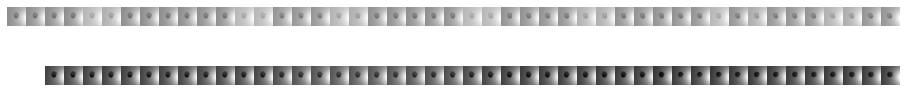

MSE of predictions:  [0.9181924  0.39887047 0.8794032  0.40294385 0.48948437 0.63435197
 0.46473807 0.47076815 0.6026245  0.7102606  0.58147943 0.57405955
 0.58090806 0.5873738  0.49117845 0.5276076  0.6373116  0.66114104
 0.6706646  0.6900785  0.72820383 0.77837384 0.6143842  0.7400632
 0.745378   0.764892   0.8619753  0.78912646 0.8061325  0.8135717
 0.80238044 0.8113347  0.82641864 1.0140464  0.7611861  0.86432344
 0.88036174 0.8954477  0.89769673 0.92626286 1.0496635  1.0835321
 0.8487775  0.9769701  0.9767469 ]


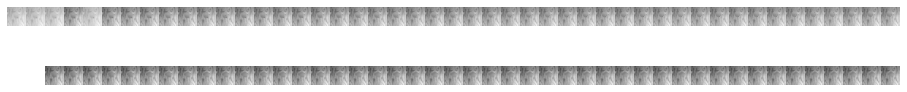

MSE of predictions:  [1.4614656  1.2159085  1.1540619  0.7702026  0.9146472  1.1307677
 0.9011251  0.69808394 0.62701213 0.67511904 0.73560846 0.75890744
 0.85291845 1.4202149  1.1345007  1.2109576  1.0659544  1.0644683
 1.0473425  1.0818535  1.4234195  1.2608974  1.2574279  1.4641831
 1.5920852  1.6317865  1.6861454  2.1537666  1.354944   1.3904908
 1.4946761  1.6316694  1.8055737  1.796207   1.7828934  1.8809978
 2.0381522  2.0346613  2.1359026  2.2002928  2.2819552  2.7391772
 2.4161115  2.6365669  2.986987  ]


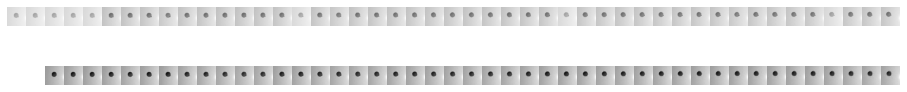

MSE of predictions:  [0.7612304  0.79799724 0.7431653  0.6335291  0.38659793 0.54803073
 0.76755506 1.2830251  0.9631419  0.6903174  0.65743196 0.8311676
 0.8489005  0.57426214 0.64653724 0.6687392  0.46118525 0.6287905
 0.9755275  1.1170135  1.5554987  0.97016263 0.66090775 1.3810835
 1.051892   1.0281255  0.7574897  0.7980852  0.8965522  0.72970366
 0.93721914 1.3629627  1.377017   1.5872557  1.2361389  1.1902726
 1.8381574  1.6682132  1.3325642  1.2857888  1.3207693  1.1241292
 1.4163736  1.9056213  1.9247482 ]


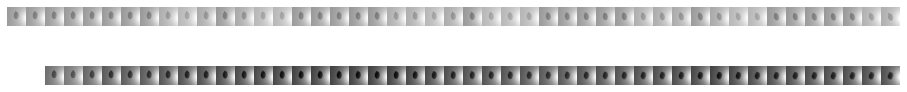

MSE of predictions:  [0.37105343 0.3752938  0.2910652  0.27856565 0.2616936  0.26943988
 0.2703678  0.28400496 0.2652256  0.25679937 0.5049549  0.55485654
 0.5065609  0.3478958  0.42119256 0.35286692 0.39229208 0.39476684
 0.42467785 0.42669666 0.4665413  0.7065003  0.74497294 0.7820227
 0.63867116 0.6866325  0.84512675 0.8035431  0.80410826 0.8415789
 0.73887    0.75051856 0.7507597  0.9975529  1.0092118  0.8796126
 0.7742125  0.8062971  0.7768751  0.8052212  0.85436845 0.9293859
 0.94562674 0.9190114  1.199877  ]


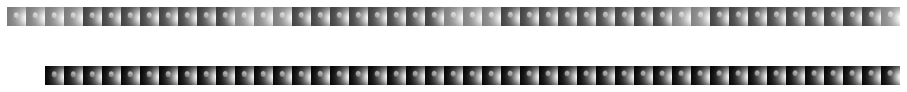

MSE of predictions:  [0.7475776  0.7669625  0.8178648  0.8341339  0.90689415 0.8352656
 1.144009   1.030492   1.2116306  1.3106415  1.6390371  1.5610273
 1.8490208  2.084893   1.9222627  2.1677554  2.1097038  1.9979521
 2.0319848  2.296505   2.3292732  2.3969471  2.4380407  2.5927048
 2.884585   3.4037025  3.8626347  3.79015    3.9186196  3.9800463
 3.7270932  4.0616217  4.28281    4.335848   4.475581   4.489279
 4.477833   4.79192    5.159896   5.2262745  5.448525   5.7506576
 5.589113   5.7724953  6.0018377 ]


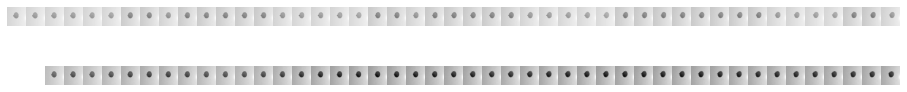

MSE of predictions:  [0.48834324 0.4672923  0.30931228 0.3381057  0.3499623  0.37164417
 0.37997085 0.40425813 0.41582716 0.42361978 0.45225173 0.379817
 0.8963465  0.47637105 0.49903232 0.51024556 0.5263938  0.53097445
 0.5467255  1.1146648  1.0936434  1.0725133  0.9052427  0.7380812
 0.47163048 0.64759    0.64750004 0.6623631  0.5239684  0.676414
 0.6674768  1.098458   0.95925426 1.0458186  0.69691443 0.70237297
 0.85627663 1.0132303  0.729664   0.72487366 0.5821461  0.5788228
 0.5713042  0.72330695 0.71495414]


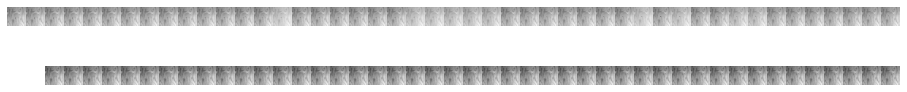

MSE of predictions:  [0.5012588  0.93361306 0.3942665  0.4404697  0.32129133 0.37694675
 0.46810377 0.8568092  0.94847727 0.6816003  0.66124356 0.72494173
 0.7420957  0.8109333  0.89164114 0.8424744  0.82805884 0.84201646
 0.72786236 1.192797   0.89715666 0.93332994 1.1406974  1.1644397
 0.914534   0.8891001  0.86035764 0.9316448  0.9293672  0.9716892
 1.3359122  1.0230254  1.0092098  0.98414606 0.9086875  0.98174554
 1.0469378  1.1347986  0.9107843  0.89317393 1.300271   1.0978884
 1.2071934  1.2226232  1.2005646 ]


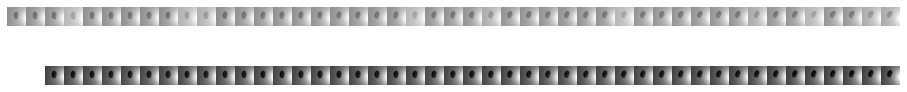

MSE of predictions:  [0.5677706  0.5618595  0.7309906  0.96341264 1.6535678  1.5607775
 1.5861418  1.6610897  1.6714762  1.9094511  1.9100941  2.0463972
 1.8768727  1.868084   1.913338   2.1196036  2.189937   2.3962436
 2.0848804  2.1317863  2.2069504  2.6085703  2.274584   2.6327376
 2.3502789  2.444458   2.853299   2.7312062  2.7460582  2.688659
 2.7076657  2.7533808  2.9265373  2.8423824  2.9651885  2.8834043
 3.0031404  2.911054   3.0390143  3.040349   3.1518366  3.0858717
 3.1209667  3.1829367  3.28162   ]


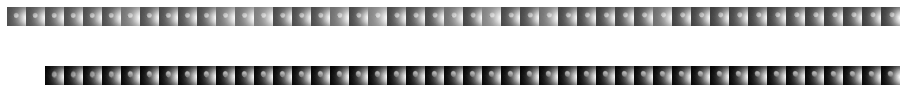

MSE of predictions:  [1.0300041  0.99351984 0.71876913 1.041865   1.2963946  1.2353281
 1.2368003  1.3614639  1.5586646  1.6835784  1.6808773  1.8560603
 1.9707445  2.5243902  2.2824059  2.3762643  2.4559264  2.581673
 2.8162897  3.4621263  3.2412906  3.3821058  3.4043193  3.6326447
 3.770558   3.9451602  4.1445346  4.3408675  4.3548794  4.4419904
 4.592428   4.901034   5.1239376  5.3112535  5.3824854  5.66674
 5.8045106  5.93182    6.2045984  6.258267   6.2971773  6.432752
 6.683488   6.7585306  6.9020844 ]


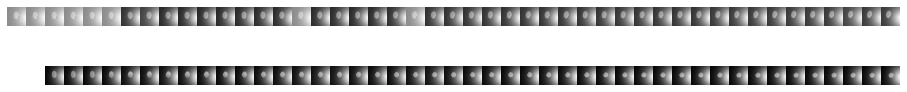

MSE of predictions:  [0.719743   0.32685792 0.27646944 0.26505122 0.43301076 0.29997465
 0.30478004 0.19483045 0.19222976 0.22777462 0.26488587 0.45743
 0.34559834 0.36113307 0.60994095 0.4272102  0.41576493 0.4633462
 0.6790658  0.6441399  0.7820562  0.7514163  1.1315551  1.3097662
 1.1885128  1.4086201  1.7922773  1.6249678  1.5530227  1.420237
 1.365227   1.8052897  1.9025536  1.3736277  1.5207183  1.4547646
 1.6967516  1.2846408  1.303584   1.3155005  1.873029   1.8819895
 1.9924521  1.9304022  1.9482876 ]


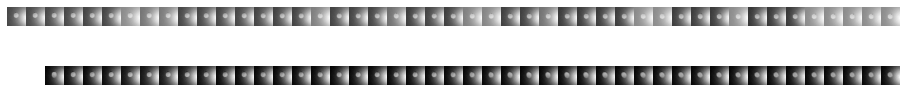

MSE of predictions:  [0.76599264 0.66065663 0.679754   0.8240664  1.1928985  1.2715896
 1.548795   1.8259712  2.2765727  2.5132103  3.1033084  3.2772753
 3.2388036  3.1684852  3.4290938  3.5213666  3.8614123  4.800099
 5.03182    4.8927307  4.879087   5.0838127  5.1944036  5.4972286
 5.882131   6.3996058  6.4618306  6.873746   7.2613287  7.5835447
 7.5843945  8.322464   8.061735   8.270361   8.502022   8.768959
 8.85927    8.951173   9.451193   9.066342   9.065163   9.062874
 8.741005   9.077516   8.960405  ]


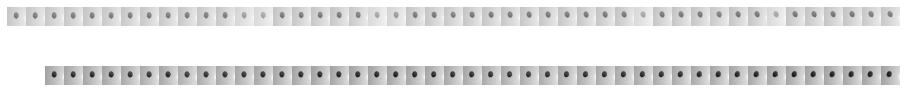

MSE of predictions:  [0.35176927 0.30589822 0.7651852  0.60254765 0.96843237 1.5021578
 1.9935207  1.5247982  1.5140915  1.4782202  1.4869581  1.5110316
 2.0575428  1.7584426  2.2656748  2.0006611  2.113306   2.15783
 2.2195036  2.278247   2.4425292  2.550792   2.6875594  2.723329
 2.798449   2.9307272  3.397874   3.1062763  3.2024198  3.0147252
 3.0808334  3.1522822  3.3095338  3.3737688  3.407527   3.434028
 3.468458   3.4490042  3.4547675  3.4142401  3.476115   3.5109754
 3.4859624  3.4909673  3.4603162 ]


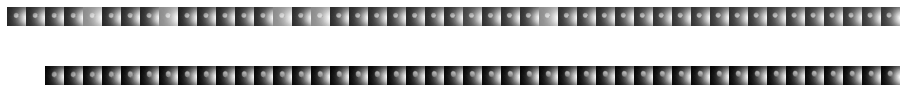

MSE of predictions:  [0.4918536  0.51141983 0.8172021  1.2812815  1.2045019  1.0580449
 1.4501592  1.4607427  1.4519361  1.4636699  1.5250417  1.2698063
 1.4120324  1.3286507  1.3595005  1.397744   1.3531073  1.4223197
 1.8995218  1.9680107  1.9885693  2.0472283  1.9762381  2.0262976
 2.027992   2.1553025  2.1408958  1.9888878  2.0245028  2.0355864
 2.0807781  2.5592377  2.8411758  2.8602583  2.8822012  2.6042132
 2.4460828  2.3624191  2.3763916  2.3725905  2.3397837  2.371362
 2.7171721  2.683758   2.6380253 ]


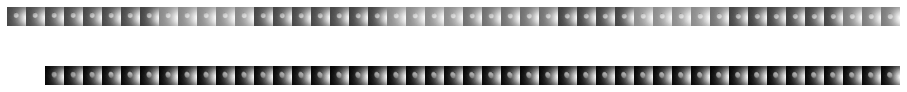

MSE of predictions:  [0.82121176 0.7118134  0.6530687  0.70073056 1.0895245  1.4517426
 1.723885   1.8859178  2.4161518  2.2355762  2.1599612  1.9917879
 2.766145   3.0197515  3.332275   3.7149572  3.550951   3.7515516
 3.9093971  4.3333488  4.7387495  4.6999817  4.936279   4.962955
 5.0532513  5.4654126  5.437682   6.15545    5.6188593  5.903802
 6.5902524  6.275522   6.259462   6.4013023  6.8137817  7.081846
 7.520589   8.161971   8.1882     8.375827   8.7114935  8.971966
 9.698894   9.615723   9.674147  ]


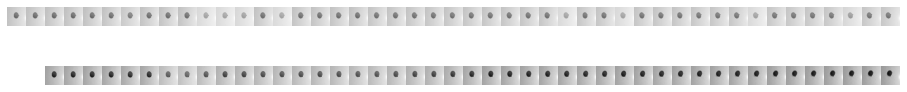

MSE of predictions:  [0.4564647  0.38461706 1.045404   0.9331106  1.9481344  1.7273657
 1.7430067  1.657902   1.2493441  1.5416431  1.1777462  1.1924706
 1.30932    1.4175632  1.3613627  1.5408044  1.5154107  1.7514833
 1.6260309  1.4991136  1.552885   1.4637775  1.8638132  1.805684
 2.3862634  1.8773392  1.6343689  1.6567373  1.8273382  1.7630186
 2.1007788  2.4825368  2.7947235  3.0875     3.2485757  3.6333222
 3.4161634  3.4089441  3.5583491  4.149827   4.1465597  4.640657
 4.6111274  4.871069   4.955889  ]


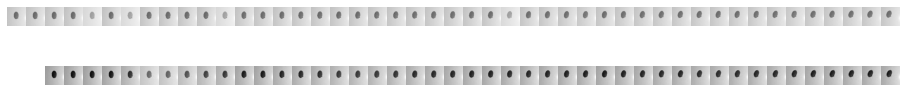

MSE of predictions:  [0.36016184 0.25665858 0.1805904  0.38309777 0.36007833 0.23455049
 0.21303098 0.23149663 0.22660765 0.53519005 0.66263497 0.4113931
 0.31155783 0.5789527  0.49425998 0.8281896  0.763208   0.4598129
 0.4549252  0.71853095 0.70272934 0.84514815 0.57863325 0.60432184
 0.5814173  0.838583   0.90969014 1.0996444  0.8121859  0.7770064
 1.0784436  1.0334892  1.040647   1.4373084  1.1920773  1.1815422
 1.1874776  1.2536216  1.2608346  1.159694   1.158159   1.4871318
 1.410387   1.4286739  1.4961258 ]


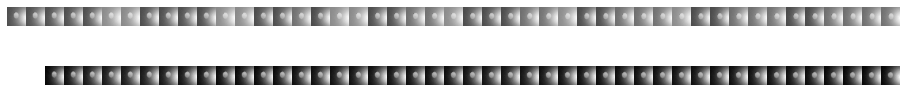

MSE of predictions:  [0.30218822 0.30845702 0.34536305 0.3611758  0.80318546 0.9725329
 1.237433   1.2662725  1.3130323  1.537776   1.5454519  1.5607038
 2.0151095  1.682864   1.7757237  1.832221   1.8803716  2.0709054
 2.211622   2.8205867  2.7538245  2.7927613  2.4909153  2.5380113
 2.6395211  2.7095463  3.2176263  2.998144   3.1529734  3.0455232
 3.1044924  3.1227994  3.2271311  3.666804   3.3723505  3.4623158
 3.5880349  3.570047   3.6961093  4.085676   3.750886   3.8993926
 3.9793293  4.09785    4.250536  ]


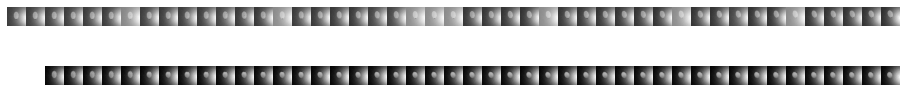

MSE of predictions:  [0.21609354 0.18134806 0.5010453  0.56846225 0.25812083 0.2908569
 0.30698523 0.3475798  0.4771405  0.78573364 0.43851    0.4971995
 0.52693194 0.5470116  0.5668114  0.98839664 0.63302493 0.6867236
 0.7439578  1.1247262  0.81801486 0.8695115  0.92134154 0.91633797
 1.2265832  0.9739195  1.0255493  1.42852    1.1173686  1.183247
 1.586442   1.2760801  1.3517046  1.8240527  1.8324332  1.7474258
 1.8133397  1.4634295  1.3718154  1.8025928  1.7879751  1.4610815
 1.5425093  1.5458388  1.4019028 ]


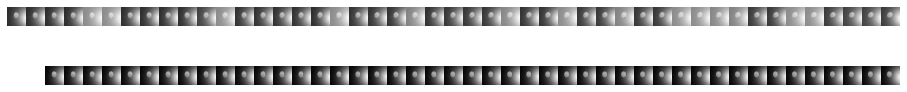

MSE of predictions:  [0.7090553  0.62319595 0.6042847  0.6111702  0.7784755  0.971872
 0.9000295  0.916192   1.0801908  1.0545276  1.0833158  1.1891556
 1.2430773  1.2765954  1.4481006  1.4746792  1.2628304  1.4013121
 1.5009825  1.5278141  1.4469477  1.4826472  1.4604938  1.4793859
 1.2967999  1.7682463  1.4183474  1.529068   1.9649882  1.685535
 1.8173063  2.411573   2.0788093  2.2240214  2.9095445  2.8712838
 3.1144404  2.8888474  3.1522803  3.0964847  2.543045   2.6051354
 2.880058   3.5630465  3.785542  ]


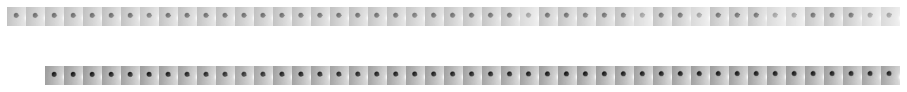

MSE of predictions:  [1.2208793  0.9303014  0.66573966 0.819767   0.80980635 0.9828609
 1.2488254  1.308895   1.3273457  1.6679167  1.5115016  1.5430665
 1.5848393  1.5848317  2.116872   2.1268458  1.8426652  2.0909266
 2.065339   1.8620033  1.9824398  1.9925429  1.9884166  2.4736278
 2.5851579  2.8053465  2.7113538  2.570952   2.2181976  2.5253148
 2.7491612  2.9306414  3.1874485  3.439571   3.2372823  2.8868222
 2.5288498  2.4025497  2.427497   2.3740668  3.1815243  3.3549428
 3.138257   2.8863845  3.0036845 ]


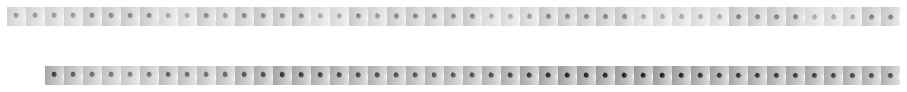

MSE of predictions:  [1.5540532  1.3725436  0.8131362  0.7074962  0.43480647 0.4346875
 0.22452962 0.20767856 0.61340714 0.6793944  0.7088217  0.3284379
 0.22693695 0.59107524 0.5529771  0.56415343 0.45159823 0.45708132
 0.65100014 1.0174248  1.1556798  1.2337606  1.3471519  1.2855743
 0.88611555 0.7856274  0.85087156 1.2561369  1.0375555  0.95989156
 0.9544786  1.4993985  1.4735272  1.4975362  1.1795926  1.2807747
 1.3243124  1.7598944  1.7954103  1.5961843  1.6952609  2.1521604
 1.794704   1.8648999  2.2693167 ]


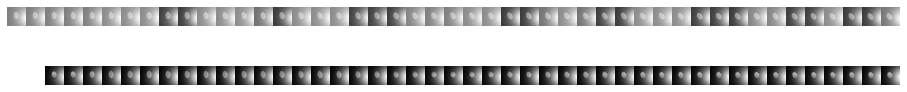

/home/olimoyo/visual-haptic-dynamics/saved_models/mit/1487682_mit_nstep2_1024optbase_noAnnealkl_noWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_va_r1.00_kl1.00_lr3e4
MSE of predictions:  [0.18301395 0.12901786 0.5175371  0.5084977  0.23584685 0.24221693
 0.34915465 0.29980347 0.37484527 0.30155885 0.65983343 0.35205066
 0.36792693 0.38190973 0.4516071  0.42124337 0.4361239  0.5132214
 0.5097065  0.5596438  0.6233001  0.63471246 0.675516   0.6686305
 0.76939976 0.81976724 0.7380546  0.7908858  0.8393695  0.9303213
 1.0006398  1.0542071  1.0609605  0.9968807  1.0541339  1.1238183
 1.2688859  1.1927222  1.3010848  1.4490507  1.4671228  1.7024977
 1.5871431  1.6986802  1.8612045 ]


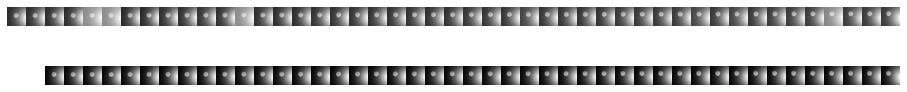

MSE of predictions:  [1.3952503  1.3586961  1.418389   0.6607871  0.30296952 0.30989882
 0.788244   0.78916794 0.29268426 0.29493558 0.18687107 0.19489406
 0.60753155 0.27044994 0.27878058 0.28560078 0.18342945 0.18880537
 0.68721133 0.27417034 0.27420345 0.28424814 0.2992172  0.30273318
 0.31066298 0.4111752  0.4148098  0.33126533 0.34218162 0.35850763
 0.35803893 0.3543189  0.35676122 0.35312903 0.25673062 0.26346248
 0.37468368 0.38613042 0.40392366 0.27590266 0.29439747 0.30287266
 0.41890454 0.43833166 0.43452725]


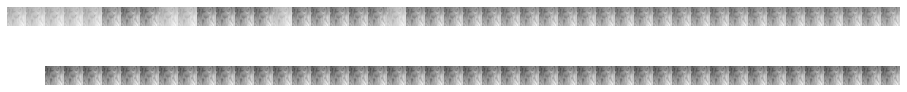

MSE of predictions:  [0.3826574  0.29112893 0.27743334 0.41159022 0.18747395 0.18884557
 0.6754294  0.30147377 0.4426127  0.32381523 0.3270402  0.33477333
 0.7950607  0.552213   0.31765667 0.3225586  0.32764232 0.3276018
 0.75048745 0.7480307  0.74037933 0.60434085 0.53593194 0.6280179
 0.29869252 0.29489544 0.29510558 0.21463414 0.22520077 0.31821656
 0.32102597 0.4591933  0.24257421 0.35797012 0.35322815 0.7865395
 0.34606844 0.3585961  0.36194372 0.36044335 0.36297905 0.9732947
 1.1537975  0.43356663 0.44749743]


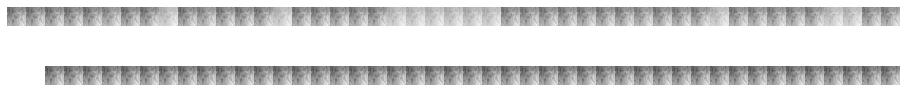

MSE of predictions:  [0.61463666 1.0727632  1.0692178  0.5724464  0.5840653  1.088492
 0.9276995  0.9174961  0.9696685  0.72738135 1.326742   1.2134372
 0.7393429  0.78206915 0.64784366 0.99334073 1.1364199  0.9346609
 1.5299224  0.9256327  0.98700607 0.9530261  1.4305525  0.95780206
 0.95355165 1.0053871  1.2905214  1.2730978  1.3035694  1.3481666
 1.7833263  1.4928248  1.2672043  1.2737417  1.1893963  1.2710261
 1.4385887  1.4888273  1.9984634  1.6037972  1.6450372  1.6635612
 1.7325666  1.7394686  1.7933062 ]


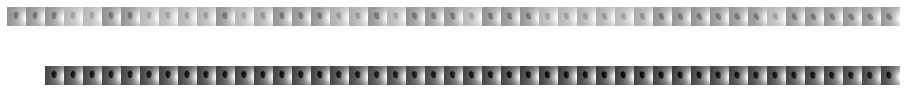

MSE of predictions:  [1.207426   1.1484536  1.1240764  0.8362964  0.8324382  1.2978332
 1.3657743  1.022772   1.0865469  0.95612407 0.9509035  0.99555755
 1.7160714  1.3161938  0.9305024  1.03924    1.0455216  1.4983695
 1.3652762  1.1882325  1.2021809  1.2907963  1.4245056  1.6410418
 1.4398184  1.5537357  1.4902413  1.4352373  1.7811736  1.6857245
 1.6470525  1.6821566  1.6798251  2.1511445  2.0023541  1.8907077
 1.9232359  1.720932   1.8864523  2.4170668  2.1083584  2.1835787
 2.1904805  2.3751037  2.4480581 ]


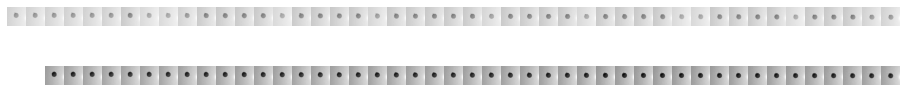

MSE of predictions:  [0.98961246 0.85573614 0.5852932  0.6027653  1.27813    1.0928993
 1.359216   1.5409279  1.5018023  2.2256258  2.371459   2.1502383
 2.325303   2.4171166  2.7200856  3.0832682  3.133966   3.5720735
 3.6899438  3.7590718  4.12966    4.3193235  4.674878   5.592221
 5.2803245  5.6433005  5.926344   6.0363507  6.177781   6.4483614
 6.485197   6.9394865  6.942927   7.9978347  7.967002   8.329075
 8.320669   8.529737   8.700127   9.041444   9.378523   9.541529
 9.230134   9.454552   9.501359  ]


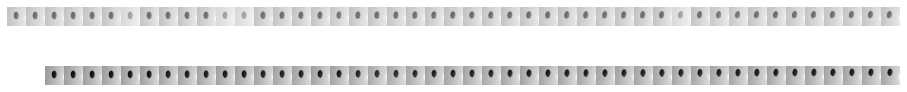

MSE of predictions:  [0.69187456 0.56493914 0.5590045  0.36697415 0.3842281  0.82271034
 0.8890306  0.9176502  0.91803247 0.68784845 0.72654736 0.789381
 0.9650723  0.99619865 0.7662612  1.2589873  0.9358193  1.4014295
 1.4124242  1.4382203  2.042573   2.0810828  1.8937513  1.8771629
 1.5254681  1.2041086  1.248229   1.3115299  1.4750514  1.9445937
 2.380601   2.4230826  2.4551995  2.1475873  1.9970326  2.04382
 1.8800592  1.7113276  1.7338736  1.774566   1.8048526  2.3547978
 2.4015837  2.198448   1.8685956 ]


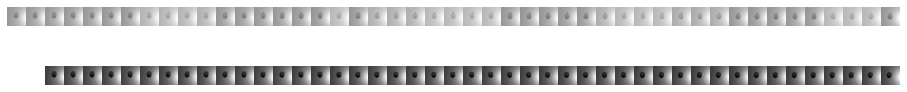

MSE of predictions:  [0.61752737 0.5205845  0.3795992  0.6652624  0.9378305  0.5203419
 0.8159239  0.44228283 0.44392416 0.58696437 0.25830552 0.26169986
 0.968981   0.857134   1.1559536  0.43621892 0.5663517  0.28784898
 0.29245687 0.30975148 0.75710326 0.9049909  0.89274055 0.5944449
 0.47979516 0.35183126 0.3627495  0.35910875 0.9452341  0.6286715
 0.89635354 0.6376192  0.53163004 0.4158346  0.41551733 0.85602105
 0.7157226  0.5457382  0.67697644 0.57267106 0.5923513  0.4889354
 0.49734902 0.9466672  0.6308726 ]


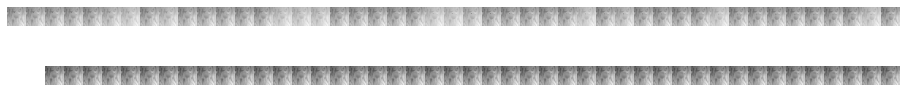

MSE of predictions:  [0.7334326  0.36955795 0.82308155 0.8319592  0.8360546  0.34907907
 0.77448875 0.36165264 0.8353567  0.84592557 0.7185484  0.53290987
 0.5452491  0.8588828  0.8673204  0.7476019  0.41505343 0.43416423
 0.30515498 0.76470864 0.7743689  0.7758443  0.44915947 0.45777154
 0.322734   0.7702841  0.78169143 0.4490968  0.44622844 0.45520744
 0.33342677 0.77570987 0.8034127  0.4645478  0.4802674  0.47873697
 0.37462544 0.8055316  0.4985641  0.50747967 0.520035   0.42626268
 0.8653257  0.89028794 0.56195605]


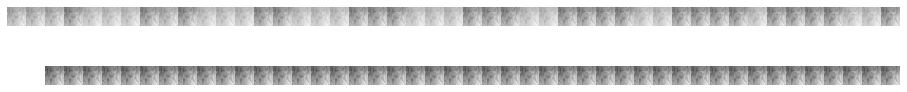

MSE of predictions:  [0.8212676  0.6296731  0.38523537 0.27704534 0.29796517 0.7406745
 0.34967017 0.29262117 0.34343457 0.3077553  0.6947032  0.71820176
 0.41920042 0.42957664 0.46485993 0.47002962 0.91513634 0.6396254
 0.71323454 0.73363036 0.707022   0.7497818  0.87879086 1.2806158
 1.3379624  1.093405   1.2213913  1.2618049  1.298703   1.6886706
 1.4363313  1.5299973  1.4759719  1.4936965  1.7486699  1.4817077
 1.4501551  1.3844312  1.3630795  1.346708   1.3104398  1.2755458
 1.2010696  1.1624374  1.1383332 ]


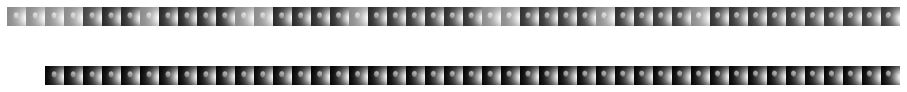

MSE of predictions:  [0.53336376 0.4867782  1.0653884  0.8349771  0.4864312  0.5119535
 0.5406108  0.36958236 0.5208112  0.53046775 1.010673   1.0147505
 0.74094045 0.59068346 0.6157093  0.82580364 0.76951003 0.5220892
 0.54405475 0.57290006 0.44905245 0.6216463  1.1659395  1.1985295
 1.0548359  0.7594407  0.79583263 0.8415283  1.1655866  1.3501801
 0.9887681  1.02479    0.87318707 0.9244585  1.1780561  1.7602204
 1.4344721  1.7225401  1.3636435  1.4042375  1.433455   1.7964981
 1.9592593  1.5968066  1.6445944 ]


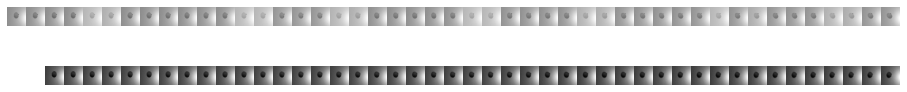

MSE of predictions:  [0.74894416 0.338957   0.8370253  0.31087703 0.31705755 0.3222026
 0.20637326 0.21667197 0.32827437 0.43926698 0.33195403 0.3289331
 0.33834457 0.34169552 0.2357913  0.26274174 0.381054   0.39785963
 0.4066223  0.40905014 0.44681692 0.499308   0.34665114 0.45797306
 0.46069896 0.48481226 0.59545565 0.48636362 0.50444293 0.5095075
 0.5182917  0.52276427 0.5373392  0.7311615  0.50357413 0.57685626
 0.5943867  0.6099919  0.63663054 0.66610134 0.78729606 0.82010067
 0.5907726  0.7070647  0.7217569 ]


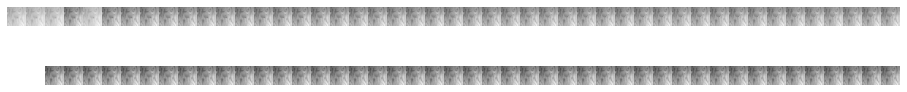

MSE of predictions:  [1.1935846  1.1639401  1.1465604  0.71382415 0.83111143 1.3443544
 1.2995852  1.1284435  0.99294263 1.1887689  1.471849   1.7480578
 1.9377636  2.616343   2.186305   2.361342   2.374695   2.4865348
 2.5427573  2.5907981  3.1039295  2.983124   3.0933404  3.4170935
 3.669773   3.7577631  3.9613843  4.5511384  3.9213195  4.0646515
 4.3664165  4.4541016  4.6003265  4.6924934  4.825271   5.081927
 5.122875   5.258954   5.376993   5.3389883  5.4185047  5.8661804
 5.599821   5.7887745  6.14406   ]


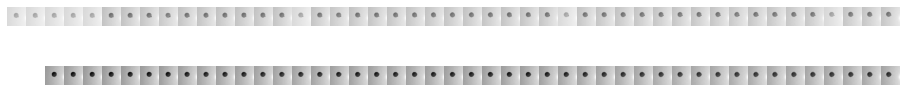

MSE of predictions:  [0.7495643  0.59685504 0.5940243  0.6277049  0.43536383 0.693943
 1.008458   1.5516593  1.266105   0.9930508  0.95245135 1.0834031
 1.1157818  0.8689885  0.9480669  0.9838956  0.8464744  0.9691313
 1.3147563  1.4741778  1.8954061  1.4227908  1.1654544  1.8455024
 1.6462831  1.6797489  1.4662528  1.4967492  1.6216208  1.5259666
 1.716492   2.1188068  2.1440024  2.3732307  2.108583   2.0410044
 2.659481   2.5843635  2.2671924  2.2001886  2.2706463  2.072685
 2.3979752  2.858992   2.9619482 ]


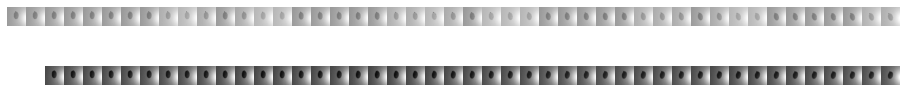

MSE of predictions:  [0.35110685 0.3590685  0.26463926 0.2641776  0.22624946 0.24246702
 0.2507117  0.29347932 0.3340559  0.3662349  0.68123806 0.8023274
 0.8188379  0.7298932  0.90389174 0.88516545 1.0304334  1.1149025
 1.1912386  1.2491621  1.3606739  1.6147814  1.6747704  1.8020141
 1.7264009  1.8276919  2.0222893  2.0619211  2.1404576  2.216827
 2.1085565  2.1687367  2.1855416  2.470299   2.5391898  2.45169
 2.3257477  2.4200287  2.3351376  2.3547783  2.3949728  2.4034352
 2.3968134  2.3183029  2.5218163 ]


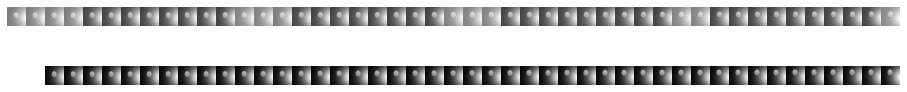

MSE of predictions:  [ 1.8349854  1.6765348  1.6316878  1.8449615  1.5715843  1.5704265
  2.199008   2.1304119  2.4709938  2.6220975  2.6718485  2.8028007
  3.3603077  3.7579615  3.7689502  4.1937466  4.1650534  4.0807853
  4.1788387  4.648016   4.875456   5.0815473  5.282196   5.4504027
  5.7709093  6.4953794  7.0763516  6.8344164  7.0439873  7.276618
  7.2154293  7.7072253  7.8054743  7.847656   8.039479   8.396633
  8.558842   9.041263   9.375225   9.429582   9.6142845 10.0067
  9.93618   10.0875435 10.385263 ]


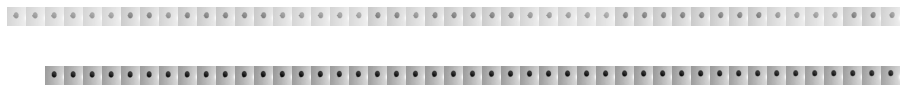

MSE of predictions:  [0.6753213  0.55517066 0.35785478 0.37462604 0.36764425 0.36340517
 0.35572875 0.37207025 0.37322527 0.37115577 0.38869488 0.3177825
 0.79733217 0.37741104 0.37502742 0.37137556 0.39858794 0.40226665
 0.4035412  0.9001713  0.90217113 0.8752528  0.6954882  0.5456743
 0.29194704 0.44876283 0.44901904 0.4470154  0.29571104 0.44816017
 0.44286907 0.8884659  0.7553123  0.82890844 0.46034142 0.45665187
 0.5917376  0.75817573 0.45637012 0.4517099  0.30394283 0.30394867
 0.3016799  0.45148885 0.45006022]


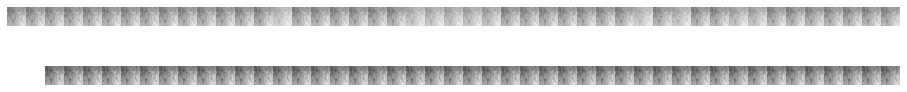

MSE of predictions:  [0.5462249  1.0268483  0.5094253  0.51658595 0.33389983 0.36345893
 0.38055292 0.8159638  0.9154332  0.5131989  0.48619547 0.51236033
 0.5249422  0.5334441  0.5715145  0.5636096  0.5887086  0.60776013
 0.47800112 0.9203969  0.6537281  0.6616638  0.93790644 0.9804108
 0.7043625  0.53140575 0.5624714  0.7231603  0.7654463  0.803049
 1.099643   0.76998985 0.79634845 0.79974365 0.66485417 0.835056
 0.90873134 1.0777357  0.70613754 0.7148833  1.1977321  1.0900745
 1.2876242  1.3326378  1.3296127 ]


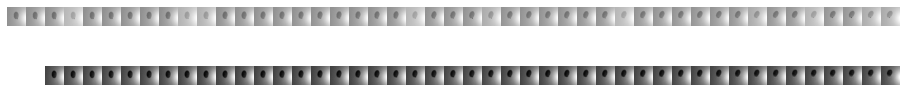

MSE of predictions:  [0.22144932 0.17056717 0.16688219 0.20775169 0.4893547  0.31200588
 0.35867944 0.31378233 0.2785629  0.42773372 0.41579702 0.50309145
 0.32614952 0.30243263 0.29886207 0.4359677  0.44422245 0.5254246
 0.31980515 0.3173261  0.29283318 0.5957355  0.31461656 0.5151941
 0.31423467 0.33142874 0.65974087 0.49800014 0.50224197 0.36413002
 0.40126997 0.38903308 0.48240507 0.37756658 0.54196143 0.34167895
 0.39421684 0.33080655 0.36997056 0.37504604 0.3554898  0.31869724
 0.3100728  0.32729918 0.42395383]


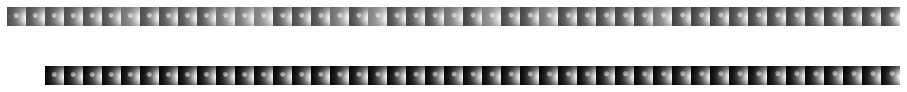

MSE of predictions:  [0.8857891  0.8846031  0.55500084 0.5621807  0.31372428 0.34297955
 0.24861178 0.26344737 0.26529753 0.2820347  0.26925611 0.27148423
 0.27872202 0.62050223 0.35763872 0.3772382  0.3449987  0.40236104
 0.45315322 0.78489196 0.5518815  0.606718   0.5893805  0.57787377
 0.6148567  0.61175907 0.6393944  0.6575628  0.6419568  0.6826645
 0.77732646 0.7410621  0.75568736 0.7647755  0.71595824 0.75176686
 0.7466389  0.7626326  0.7879012  0.677783   0.6380757  0.6376366
 0.7300247  0.7015305  0.67778957]


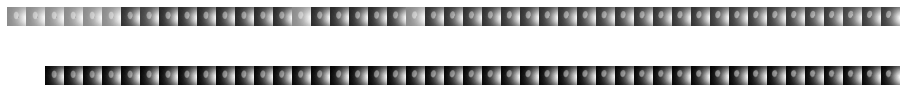

MSE of predictions:  [0.34834278 0.1914812  0.15827315 0.23883514 0.5528678  0.41707772
 0.4213555  0.23254535 0.22426856 0.23177847 0.24224176 0.38867003
 0.25374192 0.24286494 0.4358575  0.27170596 0.26924938 0.28252044
 0.44195774 0.30981365 0.50430137 0.36936182 0.57272446 0.59586394
 0.42196408 0.43677264 0.6313027  0.584849   0.56142706 0.5545205
 0.5876097  0.90564626 1.1172514  0.7744075  0.9019231  0.8849263
 1.1337173  0.8866901  0.95639217 1.0076696  1.4092195  1.4576023
 1.5421956  1.5339816  1.5554782 ]


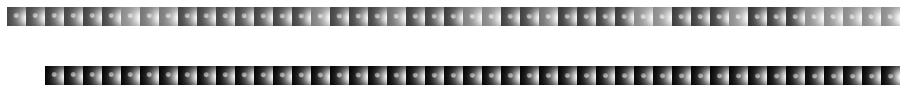

MSE of predictions:  [0.89266825 0.7150569  0.7246041  0.78758276 1.0024847  0.95413053
 0.7756418  0.9620146  1.3079143  1.3960191  1.8016393  1.8939313
 1.3741758  1.0915313  1.2374434  1.4125222  1.7085867  2.653717
 2.8479822  2.4717574  2.3383207  2.3813777  2.4864073  2.4554212
 2.860181   2.9745538  3.2111552  3.1522176  3.385386   3.546089
 3.5172014  4.290639   4.178539   4.299882   4.676216   4.775465
 4.5370955  4.7139955  5.4312468  4.9906483  5.167954   5.3511634
 5.188456   5.7451143  5.703441  ]


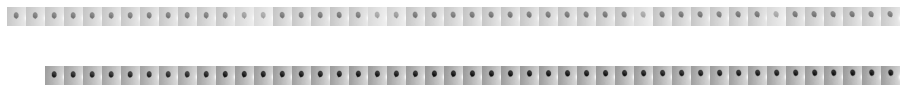

MSE of predictions:  [0.5461066  0.41262633 0.69418645 0.35614774 0.35989034 0.36922938
 0.66899216 0.30904883 0.3277217  0.2814818  0.29323927 0.33198532
 0.67996126 0.39878923 0.74359626 0.45710802 0.47496483 0.474473
 0.5569065  0.5938345  0.7595441  0.81000364 0.8081102  0.8180326
 0.81159467 0.83315647 1.1948521  0.9540708  1.0348036  1.061887
 1.1622739  1.2484299  1.3473918  1.3725896  1.409842   1.4599824
 1.5210451  1.5847068  1.6903937  1.7637526  1.7437354  1.7441667
 1.6743435  1.7193187  1.7713317 ]


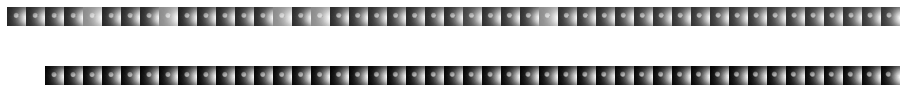

MSE of predictions:  [0.21410358 0.17574157 0.17390239 0.18160619 0.19543779 0.17139204
 0.46638077 0.45918417 0.45610568 0.46110484 0.5112392  0.32213074
 0.48625848 0.37956613 0.44833267 0.510573   0.4907053  0.54487246
 0.86894387 0.90211564 0.9485235  0.99516565 0.99374527 1.0282285
 1.0651318  1.0813822  1.0937067  0.9861928  1.035157   1.1273761
 1.156521   1.4614483  1.6442258  1.6583707  1.6914797  1.5131
 1.340513   1.3313544  1.3765142  1.4024203  1.446332   1.502991
 1.7755225  1.8095107  1.8188109 ]


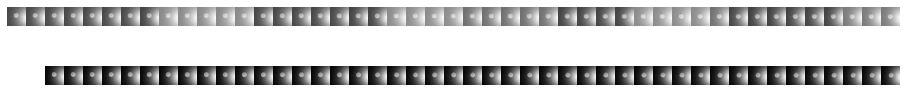

MSE of predictions:  [0.5839048  0.62086165 0.57941914 0.59160805 0.80860853 0.8559428
 0.90957314 0.85578483 1.4216202  1.3790475  1.2242597  0.6964525
 1.2365934  0.8982414  0.9874105  1.0043284  0.8103704  0.952607
 1.0106564  1.3264502  1.2830336  1.0272037  1.0476326  1.0167599
 1.0842165  1.1502244  1.1302248  1.7239342  1.0245476  1.1472305
 1.6779395  1.3385084  1.2375964  1.0905592  1.2681338  1.303236
 1.525543   1.9821941  1.5250292  1.3045981  1.4005382  1.3782557
 1.8004576  1.48733    1.4695003 ]


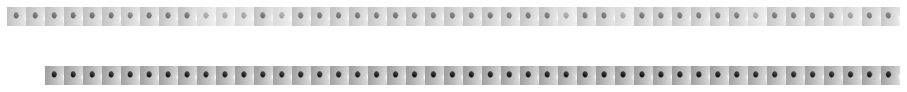

MSE of predictions:  [0.46383804 0.415975   1.0582956  0.8482215  1.571957   1.167867
 1.1800563  1.1962659  0.9418977  1.367644   1.1064948  1.1346223
 1.1382589  1.1916044  1.243153   1.7097138  1.6327953  1.6427255
 1.5335488  1.4879266  1.4582304  1.448827   1.8921577  2.0254984
 2.7117236  2.244053   1.8836378  2.004513   2.1403568  2.1389763
 2.3787372  2.5584455  2.5978904  2.364985   2.6224866  2.9285254
 2.6367059  2.8125196  2.7325773  3.2302704  3.2336216  3.3157551
 3.3099437  3.5640264  3.618987  ]


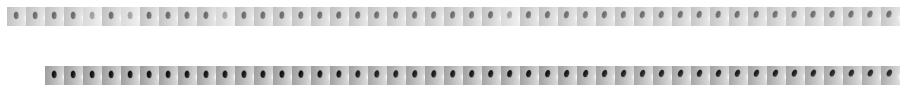

MSE of predictions:  [0.17021808 0.16544096 0.1667001  0.4479226  0.40959543 0.2576629
 0.22427791 0.21326011 0.17074746 0.42987016 0.54968315 0.3567929
 0.26847237 0.40042257 0.34480947 0.6121707  0.5618654  0.2978161
 0.28341943 0.37544298 0.36215824 0.5169041  0.31113365 0.34570742
 0.38916188 0.46555322 0.43016294 0.584758   0.4311675  0.45561108
 0.5779301  0.5344389  0.56740224 0.7461851  0.5590264  0.5934664
 0.56806123 0.5805122  0.630514   0.6588938  0.60629773 0.7301153
 0.67608744 0.7034283  0.7164127 ]


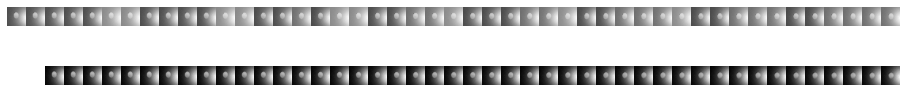

MSE of predictions:  [0.27493763 0.25251266 0.20987335 0.225153   0.56859905 0.23067045
 0.23286706 0.24939957 0.2768453  0.40529823 0.4143653  0.4088028
 0.70386136 0.45906565 0.4952787  0.5116868  0.54996145 0.7241632
 0.854602   1.1896107  1.1282703  1.1582289  0.949473   1.0104136
 1.0650876  1.105819   1.4399066  1.2739406  1.3314426  1.2642219
 1.2547225  1.1775328  1.1121821  1.3999093  1.1943742  1.2287207
 1.1918286  1.0789491  1.0705112  1.3267558  1.0302396  1.1057457
 1.0949624  1.0914973  1.0556078 ]


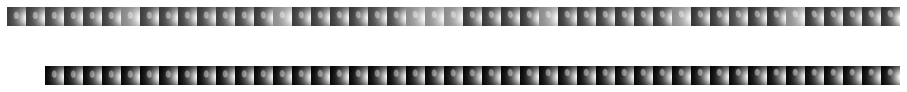

MSE of predictions:  [0.1937574  0.1858824  0.5127022  0.5478489  0.21642715 0.26479
 0.31415743 0.35960284 0.52500486 0.84806    0.58591247 0.6686189
 0.7273323  0.83606535 0.91660434 1.377398   1.1814892  1.2653534
 1.3619455  1.6524026  1.5557061  1.7294524  1.8643844  1.9969695
 2.3655095  2.2516465  2.3392692  2.6700969  2.56511    2.6557875
 2.9526813  2.8370152  2.9586031  3.4048843  3.5359502  3.4589112
 3.5682917  3.4103422  3.4609368  3.7971025  3.8918066  3.72124
 3.8447983  3.8413663  3.713582  ]


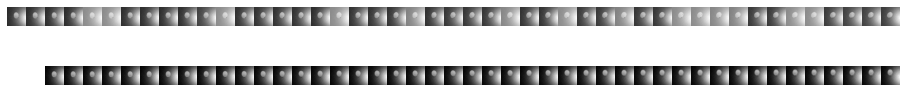

MSE of predictions:  [0.6534244  0.6585083  0.61624295 0.5978195  0.61353517 0.7770416
 0.77022356 0.8209872  0.8338144  0.82858086 0.8535935  0.86990786
 0.9161031  0.8706596  0.90605426 0.9537157  0.8363926  0.9209775
 1.0686657  1.1922879  1.1101849  1.1042043  1.1595857  1.1949353
 1.0407947  1.7881539  1.3963506  1.4400629  1.8209685  1.44439
 1.5036206  2.03084    1.1246905  1.2000871  1.8841633  1.8192083
 2.2432966  2.1026263  2.1857448  2.231661   1.524451   1.5716879
 1.9793278  2.8131936  3.2423887 ]


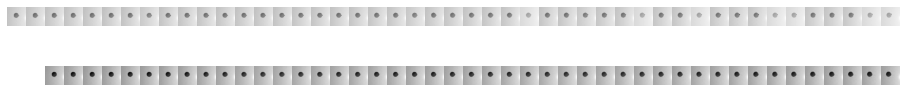

MSE of predictions:  [1.3855152  1.2668295  1.0673207  0.93099874 0.9758961  0.8415539
 1.2274607  1.201709   1.074825   1.4039942  1.2767427  1.112891
 1.2272615  1.0508178  1.4334464  1.4678544  1.2747562  1.6582017
 1.7042096  1.5446727  1.6982396  1.6179059  1.7290313  2.3044698
 2.5194283  2.7211883  2.7583108  2.5820324  2.252767   2.255285
 2.4365141  2.8637078  3.3310366  3.6783667  3.4870605  3.405242
 3.0346525  3.0361485  3.1553411  3.077837   3.911139   4.0524216
 3.795062   3.5249405  3.815611  ]


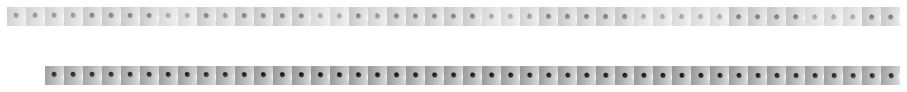

MSE of predictions:  [0.645225   0.3471092  0.4037339  0.7409453  0.5128838  0.5038584
 0.25417918 0.22548276 0.67015195 0.7300579  0.7500491  0.34962204
 0.23344854 0.55297345 0.5226665  0.52977157 0.36498213 0.28029722
 0.29037607 0.548751   0.504302   0.49430948 0.7280427  0.6783221
 0.33279815 0.34965688 0.5639714  1.0089719  0.7327466  0.5968089
 0.5552909  1.0627749  1.0586233  1.0799891  0.80846363 0.8834469
 0.91597086 1.3333797  1.3697866  1.1918901  1.2746248  1.7704978
 1.3962243  1.4433676  1.787682  ]


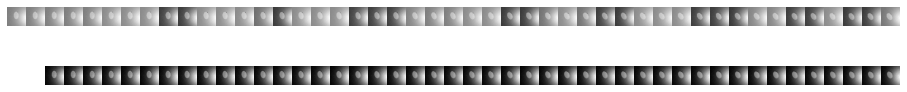

In [14]:
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)

def plot(x_img, x_hat, mse):
    # Plotting
    for bb in range(n):
        columns = args.n_initial + args.n_pred
        rows = 2
        fig=plt.figure(figsize=(16, 2))
        for ii in range(columns*rows):
            empty=False
            if ii<((columns*rows)/2):
                img = x_img[bb,ii,0,:,:]
            else:
                idx = int(ii-((columns*rows)/2))
                if idx < (T + 1):
                    empty = True
                else:
                    img = x_hat[bb,idx-1,0,:,:]
            if not empty:
                ax = fig.add_subplot(rows, columns, ii+1)
                plt.imshow(img, cmap="gray")
            plt.axis('off')
        print("MSE of predictions: ", mse[bb])
    #     fig.tight_layout()
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.1725)
        plt.show()

for k,v in analysis_data.items():
    print(k)
    plot(v["x_img"], v["x_hat"], v["mse"])